# Movement Patterns of Migrant Birds in the Western U.S. and Canada: an exercise using ebird data

## Data Collection / Import

### ebird data download

Data were downloaded from ebird https://science.ebird.org/en/use-ebird-data/download-ebird-data-products for 7 US States and 1 Canadian Province. They are (in order of data volume): Nevada, Idaho, Utah, British Columbia, Oregon, Arizona, Washington, and California. All records of all species were downloaded.

### import to PostgreSQL using PGAdmin4

Data files were large, so I decided to first import them into PostgreSQL using PGAdmin4. I first created tables within which to put the data (this code can be seen in the SQL code file located within the github repo). I then used the import GUI to import the data which came from the website as tab deliminated UTF-8 text. The import of data from Nevada (the smallest set of data at 1.4GB), was uneventful but I got an import error on the Idaho file which required much troubleshooting to fix. It became apparent that the raw data would have to be first filtered through a script in python to eliminate likely sources of import error such as lone backslashes within a cell, and backslash followed by periods at the end of strings. See below for the script that was used to 'clean' the rest of the datasets before import. 

### data was run through a cleaning script using Python in a Jupyter Notebook

The code below was used to clean the data, line by line, of characters causing import errors.

In [ ]:
import csv
import re

# Replace 'input_file.txt' with the path to the original data file
input_file_path = 'C:\\Users\\Public\\Documents\\AZindex.txt'
# The cleaned up file will be saved as 'cleaned_file.txt'
output_file_path = 'C:\\Users\\Public\\Documents\\cleaned_arizona.txt'

# Adjust this list to include the column indexes (0-indexed) that you suspect may contain problematic characters
# This could speed up the script run time if there are only a few columns where problematic entries occur.
columns_to_check = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]  # Example columns

# This chunk of code is what looks for problematic characters. You can add more with more 'if' statements. This worked for me:
def is_clean(text):
    # Check for the specific pattern '\.'
    if '\\.' in text:
        # Replace '\.' with '.' to correct the pattern
        text = text.replace('\\.', '.')
    # Check for the specific pattern '\'
    if '\\' in text:
        text = text.replace('\\','?')
    # Make sure there are no problematic other characters not compatible with UTF-8 encoding.
    try:
        text.encode('utf-8')
        return text
    except UnicodeEncodeError:
        return False
    return True  # Return the cleaned or original text

with open(input_file_path, 'r', encoding='utf-8', errors='ignore') as infile, \
     open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:

    reader = csv.reader(infile, delimiter='\t')
    writer = csv.writer(outfile, delimiter='\t')

    # Initialize a counter for the line number
    line_number = 0

    max_column_index = max(columns_to_check)  # Get the highest column index required

    for line in reader:
        line_number += 1  # Increment the line number counter
        if len(line) > max_column_index:  # Check if line has enough columns
            for i in columns_to_check:
                line[i] = is_clean(line[i])  # Clean the specific fields of the line
            # Code to handle writing the line 
            writer.writerow(line)  # Write the cleaned line to the outfile
        else:
            # The line does not have enough fields
            print(f'Incomplete data at line number: {line_number} - Skipping this line')
            continue  # Skip this line

print(f'Cleaning process completed. The cleaned file is located at {output_file_path}.')

### Problematic lines were read and deleted if necessary.

Even after the script, sometimes the import would stop. When that happened, I ran the line where the import stopped through the below steps, first to read it, then to delete it. The first step helped me to identify any problems that were not just a 'one-off' so that they could then be added to the filtering script above. 

In [10]:
# Replace file_path with the path to the file and problematic_line_number with the actual line number.
file_path = 'C:\\Users\\Public\\Documents\\cleaned_alberta.txt'
problematic_line_number = 5188807

with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
    for current_line_number, line in enumerate(file, start=1):
        if current_line_number == problematic_line_number:
            print(f'Line {problematic_line_number}: {line}')
            break  # No need to continue reading the file after finding the line

Line 5188807: URN:CornellLabOfOrnithology:EBIRD:OBS337469355	2015-08-20 10:09:29	32847	spuh	avibase-081D9B25	new world sparrow sp.	Passerellidae sp.				1					Canada	CA	Alberta	CA-AB	Hanna	CA-AB-FO		11			Kirriemuir, AB	L3859639	P	51.9235394	-110.3109741	2005-09-28		obsr90312	S24695215	Historical	P62	EBIRD				1	1		0	1	0			"Thin pale central head stripe, white throat, striped chest and plain belly, suggestion of central breast spot""	



In [2]:
# if all else fails, to delete that problematic line number, this code will work.

input_file_path = 'C:\\Users\\Public\\Documents\\cleaned_california.txt' # replace with file to be worked
output_file_path = 'C:\\Users\\Public\\Documents\\cleaned_california1.txt' # replace with destination of 'clean' file
problematic_line_number = 44249108  # Replace with the actual line number

with open(input_file_path, 'r', encoding='utf-8', errors='ignore') as infile, \
     open(output_file_path, 'w', encoding='utf-8', newline='') as outfile:
    for current_line_number, line in enumerate(infile, start=1):
        if current_line_number != problematic_line_number:
            outfile.write(line)
        else:
            print(f'Skipped line {current_line_number}')

print(f'File has been cleaned. The cleaned file is located at {output_file_path}.')

Skipped line 44249108
File has been cleaned. The cleaned file is located at C:\Users\Public\Documents\cleaned_california1.txt.


### Tables were cleaned and aggregated in PostgreSQL 

See the SQL code saved within this repo for the code used to clean and aggregate the data. 

50 Variables were imported in each table of the data, but most were not going to be used, so all but 15 were dropped in PostgreSQL.

The variables were imported as varchar(n) or text, and needed to be reclassified into appropriate data types to be used. Taxonomic_order and observation_count were converted to integers, latitude and longitude were converted to double precision, observation_date was converted to 'date', all_species_reported was converted to boolean. To convert observation_count to integer, all null values of 'X' needed to be dropped from the tables.

After data conversion, 42 species were selected from more than 500 identified within the dataset. This was necessary because of the size of the data and the limitations of my local computing power. I knew I needed to get the final working data table down to less than 3GB, and ideally less than 1GB. Bird species were selected based on their migration pattern (I chose those only with obvious seasonal movement patterns) and were further refined to include a good variety of birds that migrate at different times during the spring (early and late arrivers), whose northernmost range varied from central Arizona to the Yukon, and whose habitats were varied (grassland, desert, forest, taiga obligate species).

Finally, an aggregation was performed in PostgreSQL that summed all counted birds grouped by date (YYYY-MM-DD) within each county to give a measurement of each species present in each county within the study region (US and Canada west of the continental divide) on any given day throughout the history of the ebird project. Now, this is only for the 42 species selected, to serve as a 'proof-of-concept' - but this would be wildly interesting if all species could be included. I was able to distill about 60G of data down to 780M in this way. This still represents about 7.5 million rows of data.

### Data are pulled into Jupyter and combined.

In [3]:
import pandas as pd

Pull all the 8 tables into jupyter as pandas dataframes.

In [7]:
california = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\california_agg_final.csv")

In [8]:
california.shape

(2771000, 11)

In [9]:
washington = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\washington_agg_final.csv")

In [10]:
washington.shape

(1088715, 11)

In [12]:
arizona = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\arizona_agg_final.csv")

In [13]:
arizona.shape

(855698, 11)

In [14]:
oregon = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\oregon_agg_final.csv")

In [15]:
oregon.shape

(996528, 11)

In [16]:
bc = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\bc_agg_final.csv")

In [17]:
bc.shape

(875483, 11)

In [18]:
utah = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\utah_agg_final.csv")

In [19]:
utah.shape

(428163, 11)

In [20]:
idaho = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\idaho_agg_final.csv")

In [21]:
idaho.shape

(402787, 11)

In [22]:
nevada = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\nevada_agg_final.csv")

In [23]:
nevada.shape

(234425, 11)

Now, let's create a list of all these 8 tables to merge together

In [25]:
merge = (california, arizona, washington, oregon, bc, utah, idaho, nevada)

And, let's merge them into a new working file

In [29]:
birds = pd.concat(merge, ignore_index=True)

In [30]:
birds.shape

(7652799, 11)

AMAZING! The culmination of 5 days of work. I'm going to go ahead and save this to a .csv. Now, we can get started with exploratory data analysis.

In [33]:
birds.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\birds.csv", index=True)

I've now shut down jupyter and restarted to clear my local data cache. Now I'll reimport the .csv.

In [4]:
birds = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\birds.csv")

In [5]:
birds.describe()

,Unnamed: 0,taxonomic_order,total_count,mean_latitude,mean_longitude
count,7.652799e+06,7.652799e+06,7.652799e+06,7.652799e+06,7.652799e+06
mean,3.826399e+06,2.255884e+04,2.937809e+01,4.108206e+01,-1.190806e+02
std,2.209173e+06,1.204791e+04,2.858046e+03,5.846707e+00,4.301059e+00
min,0.000000e+00,2.033000e+03,1.000000e+00,3.133250e+01,-1.380278e+02
25%,1.913200e+06,1.646700e+04,2.000000e+00,3.643880e+01,-1.224791e+02
50%,3.826399e+06,2.796900e+04,5.000000e+00,4.029791e+01,-1.203465e+02
75%,5.739598e+06,3.260100e+04,1.600000e+01,4.625139e+01,-1.167492e+02
max,7.652798e+06,3.365400e+04,3.600020e+06,5.999986e+01,-1.090416e+02


In [6]:
birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7652799 entries, 0 to 7652798
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   taxonomic_order  int64  
 2   common_name      object 
 3   total_count      int64  
 4   country_code     object 
 5   state            object 
 6   state_code       object 
 7   county           object 
 8   county_code      object 
 9   mean_latitude    float64
 10  mean_longitude   float64
 11  observed_date    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 700.6+ MB


Oops. I'll have to get date back to a date and lat and long back to double precision.

In [8]:
birds["observed_date"] = pd.to_datetime(birds["observed_date"]) # change observed_date to 'date'

Latitude and Longitude will provide points, and I'd like to generate polygons from this data, which means it needsto be georeferenced. I have just spent a few hours reading about geography work in python, so I will transfer my file to geopandas to continue. Then, I need to ask it to create points from my lat and long variables.

In [9]:
import geopandas
import matplotlib.pyplot as plt
import pandas

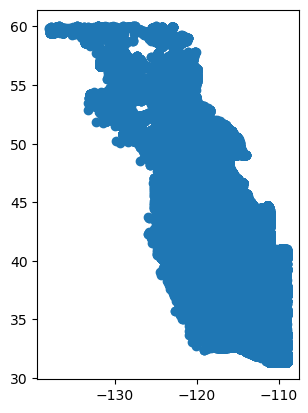

In [11]:
points = geopandas.points_from_xy(birds['mean_longitude'], birds['mean_latitude'])

birdsgeo = geopandas.GeoDataFrame(birds, geometry = points, crs='EPSG:4326')

birdsgeo.plot()

plt.show()

This looks like it's worked great!

In [79]:
birdsgeo.head(2)

,Unnamed: 0,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry
0,0,2033,Eurasian Collared-Dove,4,US,California,US-CA,Alameda,US-CA-001,37.862962,-122.314739,1983-07-04,POINT (-122.31474 37.86296)
1,1,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.585126,-121.698818,2000-08-04,POINT (-121.69882 37.58513)


In [14]:
birdsgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7652799 entries, 0 to 7652798
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Unnamed: 0       int64         
 1   taxonomic_order  int64         
 2   common_name      object        
 3   total_count      int64         
 4   country_code     object        
 5   state            object        
 6   state_code       object        
 7   county           object        
 8   county_code      object        
 9   mean_latitude    float64       
 10  mean_longitude   float64       
 11  observed_date    datetime64[ns]
 12  geometry         geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int64(3), object(6)
memory usage: 759.0+ MB


In [16]:
birdsgeo.isnull().sum()

Unnamed: 0           0
taxonomic_order      0
common_name          0
total_count          0
country_code         0
state                0
state_code           0
county             100
county_code        100
mean_latitude        0
mean_longitude       0
observed_date        0
geometry             0
dtype: int64

Okay, out of over 7.5M observations, let's drop the 100 that don't have county recorded. Those records would have been aggregated together in SQL by state/province anyways, so their lat and long will be weird.

In [77]:
birdsgeo = birdsgeo.dropna()

In [78]:
birdsgeo.shape

(7652699, 13)

<Axes: xlabel='total_count', ylabel='common_name'>

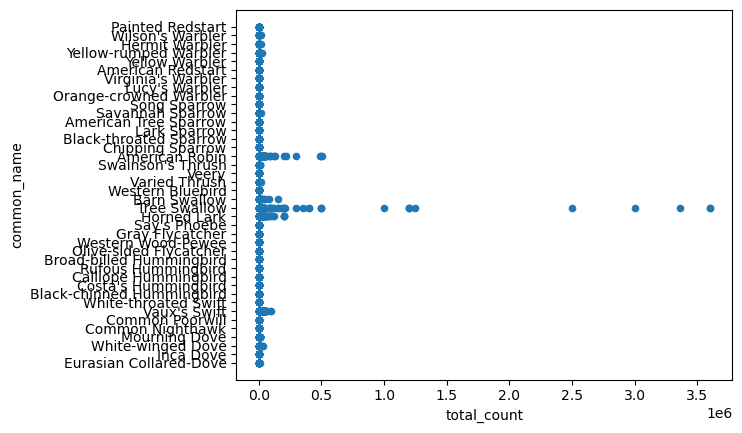

In [25]:
birdsgeo.plot.scatter('total_count', 'common_name')

Clearly, this is a problem. Apparently, American Robins congregate in central Oregon in outrageous numbers in the winter. There are as many as half a million of them recorded in Crook County, Oregon in January on some years. I'm not interested in bird density for my primary analysis, but it's not off the shelf if I have time. I'm going to cut the count at 5,000 to improve the ability to work nicely with all the species, and keep this work in my notes for later if I get to using count data for something other than presence/absence.

In [81]:
birdsgeo.loc[birdsgeo['total_count'] > 5000]

,Unnamed: 0,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry
428610,428610,3846,Vaux's Swift,8092,US,California,US-CA,Humboldt,US-CA-023,40.785351,-124.057703,2012-09-10,POINT (-124.05770 40.78535)
428616,428616,3846,Vaux's Swift,5696,US,California,US-CA,Humboldt,US-CA-023,40.785351,-124.057703,2012-09-16,POINT (-124.05770 40.78535)
428763,428763,3846,Vaux's Swift,9031,US,California,US-CA,Humboldt,US-CA-023,40.774505,-124.111847,2013-09-27,POINT (-124.11185 40.77451)
431536,431536,3846,Vaux's Swift,20000,US,California,US-CA,Los Angeles,US-CA-037,34.042845,-118.256450,1990-09-30,POINT (-118.25645 34.04285)
431544,431544,3846,Vaux's Swift,10000,US,California,US-CA,Los Angeles,US-CA-037,34.042845,-118.256450,1991-04-25,POINT (-118.25645 34.04285)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7518600,7518600,22065,Horned Lark,10000,US,Nevada,US-NV,Nye,US-NV-023,36.488523,-116.454434,2011-11-18,POINT (-116.45443 36.48852)
7519990,7519990,22065,Horned Lark,6000,US,Nevada,US-NV,Pershing,US-NV-027,40.165560,-118.476090,2017-12-21,POINT (-118.47609 40.16556)
7520067,7520067,22065,Horned Lark,75000,US,Nevada,US-NV,Pershing,US-NV-027,40.142264,-118.476155,2021-12-31,POINT (-118.47615 40.14226)
7522776,7522776,23533,Tree Swallow,10000,US,Nevada,US-NV,Clark,US-NV-003,35.195677,-114.572940,1976-03-17,POINT (-114.57294 35.19568)


In [84]:
birdsgeo.loc[birdsgeo['total_count'] > 5000, 'total_count'] = 5000

In [85]:
birdsgeo.loc[birdsgeo['total_count'] > 5000]

,Unnamed: 0,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,column1


<Axes: xlabel='total_count', ylabel='common_name'>

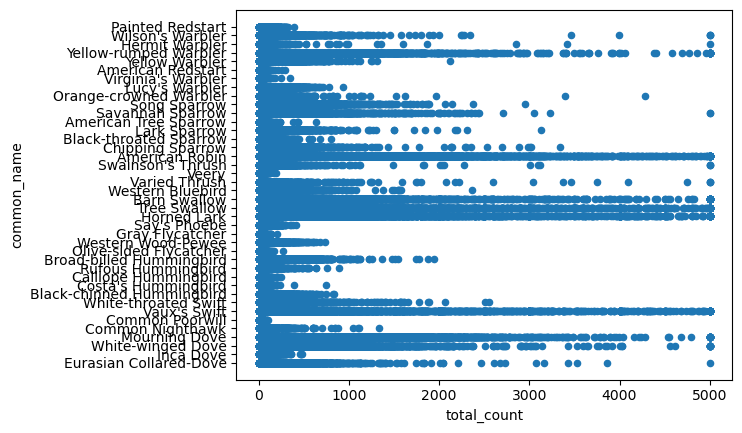

In [86]:
birdsgeo.plot.scatter('total_count', 'common_name')

(array([1]), [Text(1, 0, 'total_count')])

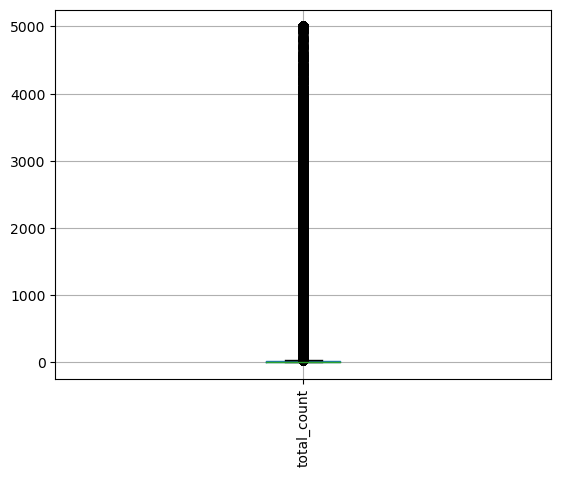

In [87]:
# this is a bit irrelevant for how I will use the data, but I want to keep in the habit of checking.
boxplot1 = birdsgeo[['total_count']]
boxplot1.boxplot()
plt.xticks(rotation=90)

In [88]:
# Let's make sure all species selected have a good number of observations.
birdsgeo["common_name"].value_counts()

common_name
American Robin               734227
Song Sparrow                 720398
Yellow-rumped Warbler        717917
Mourning Dove                569499
Eurasian Collared-Dove       493613
Barn Swallow                 375206
Orange-crowned Warbler       339648
Savannah Sparrow             313984
Tree Swallow                 301683
Yellow Warbler               266810
Western Bluebird             257320
Say's Phoebe                 230218
Wilson's Warbler             212660
Western Wood-Pewee           198524
Rufous Hummingbird           193330
Chipping Sparrow             193311
Varied Thrush                163060
Swainson's Thrush            140085
Horned Lark                  138452
Black-chinned Hummingbird    122535
Lark Sparrow                 121905
White-throated Swift         102536
Vaux's Swift                  90795
Olive-sided Flycatcher        89226
Black-throated Sparrow        63592
Costa's Hummingbird           58168
Common Nighthawk              57988
White-winged Dov

Okay, so no exceptionally rare species here. Let's now check 'state'.

In [89]:
# And again, make sure all states have high observation numbers.
birdsgeo["state"].value_counts()

state
California          2770997
Washington          1088715
Oregon               996528
British Columbia     875411
Arizona              855674
Utah                 428163
Idaho                402786
Nevada               234425
Name: count, dtype: int64

This is what I expected from the relative sizes of the data sets.

In [92]:
# Good to get an idea of the range of each variable, and how it might be shaped.
birdsgeo.describe()

,Unnamed: 0,taxonomic_order,total_count,mean_latitude,mean_longitude,observed_date,column1
count,7.652699e+06,7.652699e+06,7.652699e+06,7.652699e+06,7.652699e+06,7652699,0.0
mean,3.826381e+06,2.255884e+04,2.426927e+01,4.108200e+01,-1.190805e+02,2015-09-14 16:00:55.193703936,NaN
min,0.000000e+00,2.033000e+03,1.000000e+00,3.133250e+01,-1.380278e+02,1835-05-28 00:00:00,NaN
25%,1.913178e+06,1.646700e+04,2.000000e+00,3.643880e+01,-1.224791e+02,2013-05-03 00:00:00,NaN
50%,3.826376e+06,2.796900e+04,5.000000e+00,4.029783e+01,-1.203465e+02,2017-09-10 00:00:00,NaN
75%,5.739556e+06,3.260100e+04,1.600000e+01,4.625118e+01,-1.167492e+02,2020-12-30 00:00:00,NaN
max,7.652798e+06,3.365400e+04,5.000000e+03,5.999986e+01,-1.090416e+02,2023-09-30 00:00:00,NaN
std,2.209174e+06,1.204792e+04,1.109459e+02,5.846645e+00,4.301022e+00,NaN,NaN


Okay, so I like data... lots of data, but we can't go all the way back to 1835. Well, we CAN... but I doubt the data from way back then will be comparable or consistent enough to use with modern data. Let's see how this all looks. I need to create a 'year', 'month', and 'julian date' variable I think so that I can use time to compare these things.

In [104]:
birdsgeo = pd.DataFrame(birdsgeo)

In [105]:
birdsgeo["observed_date"] = pd.to_datetime(birdsgeo["observed_date"]) # change observed_date to 'date'

In [111]:
# isolate year from date
birdsgeo['year'] = pd.DatetimeIndex(birdsgeo['observed_date']).year

In [110]:
# isolate month from date
birdsgeo['month'] = pd.DatetimeIndex(birdsgeo['observed_date']).month

In [109]:
# create julian date from date
birdsgeo['julian'] = pd.DatetimeIndex(birdsgeo['observed_date']).to_julian_date()

In [124]:
# create day of year variable from date
birdsgeo['dayofyear'] = pd.DatetimeIndex(birdsgeo['observed_date']).dayofyear

In [125]:
# All good, now we just need to sort out which years to include.
birdsgeo.head(5)

,Unnamed: 0,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,year,month,julian,dayofyear
0,0,2033,Eurasian Collared-Dove,4,US,California,US-CA,Alameda,US-CA-001,37.862962,-122.314739,1983-07-04,POINT (-122.31474 37.86296),1983,7,2445519.5,185
1,1,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.585126,-121.698818,2000-08-04,POINT (-121.69882 37.58513),2000,8,2451760.5,217
2,2,2033,Eurasian Collared-Dove,5,US,California,US-CA,Alameda,US-CA-001,37.660119,-121.732807,2004-05-22,POINT (-121.73281 37.66012),2004,5,2453147.5,143
3,3,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.763607,-122.258200,2005-07-15,POINT (-122.25820 37.76361),2005,7,2453566.5,196
4,4,2033,Eurasian Collared-Dove,12,US,California,US-CA,Alameda,US-CA-001,37.616214,-121.694949,2005-09-10,POINT (-121.69495 37.61621),2005,9,2453623.5,253


In [132]:
# count how many observations we have on any given year. 
repyear = birdsgeo["year"].value_counts()

In [155]:
repyear.tail(5)

year
1977    7354
1976    7346
1974    7306
1975    5429
1973    4213
Name: count, dtype: int64

So, let's cut year at anything before 1973. I think 50 years is a pretty good sample!

In [139]:
birdsgeo = birdsgeo[birdsgeo.year > 1972]

In [181]:
# This now represents 'the' dataset that everything else is going to come from.
birdsgeo.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\birdsgeo.csv", index=True)

In [143]:
birdsgeo.shape

(7635779, 17)

Now, I am going to make polygons that contain all the observations of each species in each year, then I can compare the sizes of the polygons year over year by merging them and taking the difference. I will end with a table of each species/year and whether the range expanded or contracted in each one. I should be able to perform a regression on this to see if there is a pattern, as well as run that table through a clustering analysis to see if any species behaved more similarly to one another.

The first step is to make a series from every species and year so that I can make the polygons and then calculate their sizes.

In [150]:
# Let's first eliminate all the data except for year, species, and point.
birdpolygon = birdsgeo[["common_name","year","geometry"]]
birdpolygon.head()

,common_name,year,geometry
0,Eurasian Collared-Dove,1983,POINT (-122.31474 37.86296)
1,Eurasian Collared-Dove,2000,POINT (-121.69882 37.58513)
2,Eurasian Collared-Dove,2004,POINT (-121.73281 37.66012)
3,Eurasian Collared-Dove,2005,POINT (-122.25820 37.76361)
4,Eurasian Collared-Dove,2005,POINT (-121.69495 37.61621)


In [154]:
# let's get a list of all the years, and a list of all the common_names
common_names = list(set(list(birdsgeo['common_name'])))
years = list(set(list(birdsgeo['year'])))

In [165]:
# get series for each common_name/year
def get_series(common_name, year):
    iter1 = birdpolygon[birdpolygon.common_name == common_name]
    iter2 = iter1[iter1.year == year]
    out = iter2['geometry']

In [ ]:
get_series

In [160]:
# This is how to get polygons from each species, for each year, but ideally I want to loop this!
iter1 = birdpolygon[birdpolygon.common_name == 'American Robin']
AMRO23 = iter1[iter1.year == 2023]
AMRO23 = AMRO23['geometry']
AMRO23

1379179    POINT (-122.07000 37.75248)
1379180    POINT (-122.13121 37.74896)
1379181    POINT (-122.07681 37.74440)
1379182    POINT (-122.15167 37.79553)
1379183    POINT (-122.21226 37.81749)
                      ...             
7566380    POINT (-114.25428 38.95269)
7566381    POINT (-114.23777 38.96184)
7566382    POINT (-114.24007 39.01666)
7566383    POINT (-114.65269 39.46305)
7566384    POINT (-114.64588 39.34653)
Name: geometry, Length: 49046, dtype: geometry

In [170]:
# Let's loop through all the data now, and create all the polygons that are going to be used in this time series and cluster analysis.
## Using Convex Hull to contain all the points 
import geopandas as gpd
from shapely.geometry import MultiPoint

# a hull area calculation will work here to draw a polygon around all the observations in the list. Otherwise, you'd need to define the polygon
# with only the outer points and the order in which they are to be connected.
def calculate_convex_hull_area(df):
    # Group by 'common_name' and 'year'
    grouped = birdpolygon.groupby(['common_name', 'year'])
    
    # List to store the output data
    area_data = []
    
    # Iterate over each group
    for (common_name, year), group in grouped:
        # Convert the 'geometry' points to a MultiPoint object
        points = MultiPoint(group['geometry'].tolist())
        
        # Compute the convex hull of the points
        convex_hull_year = points.convex_hull
        
        # Calculate the area of the convex hull
        area = convex_hull_year.area
        
        # Store the result as a tuple
        area_data.append((common_name, year, area, convex_hull_year))

    # Convert results to a GeoDataFrame
    area_gdf = gpd.GeoDataFrame(area_data, columns=['common_name', 'year', 'area', 'convex_hull_year'])
    
    # Return the GeoDataFrame
    return area_gdf

# Apply the function to the dataset
convex_hull_areas = calculate_convex_hull_area(birdpolygon)

In [173]:
convex_hull_areas

,common_name,year,area,convex_hull_year
0,American Redstart,1973,129.886093,"POLYGON ((-117.24220305 32.67595415, -119.5107..."
1,American Redstart,1974,302.289206,"POLYGON ((-114.4665626 32.8819198, -118.520604..."
2,American Redstart,1975,126.289002,"POLYGON ((-115.0350952 32.7156663, -118.486568..."
3,American Redstart,1976,216.786103,"POLYGON ((-110.8110955 31.4991144, -117.100374..."
4,American Redstart,1977,115.117135,"POLYGON ((-117.2449932 32.68582, -119.4878153 ..."
...,...,...,...,...
2026,Yellow-rumped Warbler,2019,423.440502,"POLYGON ((-109.261533 31.3558004, -110.7376812..."
2027,Yellow-rumped Warbler,2020,400.996699,"POLYGON ((-109.261533 31.3558004, -111.12218 3..."
2028,Yellow-rumped Warbler,2021,399.640813,"POLYGON ((-109.261533 31.3558004, -110.9348942..."
2029,Yellow-rumped Warbler,2022,408.808114,"POLYGON ((-109.0694914 31.3435712, -110.253566..."


In [174]:
convex_hull_areas.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\convex_hull_species_year.csv", index=True)

This is an amazing start! However, I want each row to represent one species, and each column to represent a year, with polygon areas filling the cells. I'm not sure if I need to extract 'convex_hull_year', but I'll go ahead and do that just to prevent problems.

In [175]:
convex_hull = convex_hull_areas[['common_name','year','area']]

In [176]:
convex_hull.head()

,common_name,year,area
0,American Redstart,1973,129.886093
1,American Redstart,1974,302.289206
2,American Redstart,1975,126.289002
3,American Redstart,1976,216.786103
4,American Redstart,1977,115.117135


Okay. Now, I will pivot the table to get it looking the way I want it to!!

In [177]:
PolygonYearTimeSeries = convex_hull.pivot(index="common_name", columns="year", values="area")

In [179]:
PolygonYearTimeSeries.head()

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
common_name,,,,,,,,,,,,,,,,,,,,,
American Redstart,129.886093,302.289206,126.289002,216.786103,115.117135,205.398519,234.253657,231.216553,245.408476,182.469615,...,328.197443,337.759105,338.110870,348.075453,368.131195,395.653071,352.466573,336.882674,367.310131,357.307791
American Robin,235.026508,332.332345,297.769576,363.537287,222.551629,262.110009,351.244603,364.920917,260.570468,254.788562,...,386.993354,395.096552,403.569028,400.372374,404.092450,400.797451,397.531003,397.418039,395.081481,402.031550
American Tree Sparrow,158.408117,179.336399,319.071161,164.496778,153.082547,149.191688,242.234756,199.762190,56.895871,105.399831,...,318.489874,333.085211,340.259821,336.645467,350.866763,346.881802,355.874573,351.634079,350.822670,322.153934
Barn Swallow,221.589235,264.508121,221.118548,318.225467,224.956113,229.605150,312.558099,340.331330,268.308691,234.541690,...,412.696109,396.096570,393.653892,401.537206,401.494006,408.759980,397.003004,399.205301,393.399716,399.703728
Black-chinned Hummingbird,116.268879,78.902839,123.249152,136.641634,133.581550,133.566039,159.477559,163.413584,162.168597,83.421753,...,218.446244,224.571595,210.491259,220.521501,220.223727,221.383856,218.133286,223.338213,222.541032,221.253910


Okay, it looks like Eurasian Collared-Dove didn't work, but don't panic! That species is so interesting because it WASN'T widely introduced in those early years, but boy-howdy, you should see the size of its range today!!

In [183]:
PolygonYearTimeSeries.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\PolygonYearAreas.csv", index=True)

Now, I would also like to save the polygon data for graphical displays in the future, so I'll store those as well.

In [184]:
# pull area out of the dataset and just keep the polygons
convex_hull_2 = convex_hull_areas[['common_name','year','convex_hull_year']]

In [185]:
# pivot the table to make each row a species, columns are years, and data is the polygon
PolygonYearSpecies = convex_hull_2.pivot(index="common_name", columns="year", values="convex_hull_year")

In [186]:
PolygonYearSpecies.head()

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
common_name,,,,,,,,,,,,,,,,,,,,,
American Redstart,"POLYGON ((-117.24220305 32.67595415, -119.5107...","POLYGON ((-114.4665626 32.8819198, -118.520604...","POLYGON ((-115.0350952 32.7156663, -118.486568...","POLYGON ((-110.8110955 31.4991144, -117.100374...","POLYGON ((-117.2449932 32.68582, -119.4878153 ...","POLYGON ((-109.166851 31.8935, -117.2414321 32...","POLYGON ((-117.0838183 32.5890679, -121.916673...","POLYGON ((-109.2058731 31.8835432, -117.095159...","POLYGON ((-118.3056307 33.7494285, -118.812246...","POLYGON ((-109.2058731 31.8835432, -117.241432...",...,"POLYGON ((-110.3741764 31.5411676, -111.040829...","POLYGON ((-110.28619 31.40806, -117.084619 32....","POLYGON ((-109.261533 31.3558004, -111.1023021...","POLYGON ((-109.261533 31.3558004, -110.8543 31...","POLYGON ((-110.2392496 31.3904516, -117.084619...","POLYGON ((-110.9388225 31.37747, -117.0812827 ...","POLYGON ((-109.261533 31.3558004, -110.4540024...","POLYGON ((-110.7606337 31.5390131, -111.047042...","POLYGON ((-111.08700000000002 31.401, -117.087...","POLYGON ((-109.261533 31.3558004, -110.2738108..."
American Robin,"POLYGON ((-109.66697265 31.38318755, -110.9406...","POLYGON ((-109.2880011 31.8798171, -117.147338...","POLYGON ((-111.0644469 31.38743, -117.09776685...","POLYGON ((-110.9392548 31.3501186, -117.132945...","POLYGON ((-110.9174538 31.3660502, -117.114399...","POLYGON ((-110.2768226 31.4351879, -110.396 31...","POLYGON ((-110.3761978 31.4521999, -117.241432...","POLYGON ((-110.8566971 31.4951992, -117.244993...","POLYGON ((-110.3095318 31.4288359, -110.963699...","POLYGON ((-110.28619 31.40806, -110.631692 31....",...,"POLYGON ((-109.0694914 31.3435712, -110.239249...","POLYGON ((-110.8543 31.3769, -111.087 31.401, ...","POLYGON ((-111.1023021 31.374512, -111.242842 ...","POLYGON ((-110.6762959 31.3690619, -110.854006...",POLYGON ((-109.76794006666668 31.3590567333333...,"POLYGON ((-109.579345 31.373042, -111.1023021 ...","POLYGON ((-109.0694914 31.3435712, -110.930414...","POLYGON ((-110.8543 31.3769, -117.1335678 32.6...","POLYGON ((-111.092205 31.3887517, -117.0817724...","POLYGON ((-111.0893 31.393, -117.2414321 32.67..."
American Tree Sparrow,"POLYGON ((-116.8723547 36.4588031, -136.836605...","POLYGON ((-119.7196054 33.9961771, -121.931607...","POLYGON ((-117.1580422 32.731398, -118.5778642...","POLYGON ((-117.1928083 32.7579913, -122.73561 ...","POLYGON ((-114.381456 34.110801, -123.002789 3...","POLYGON ((-109.3061496 34.1555035, -123.002789...","POLYGON ((-117.2928223 35.0106763, -122.995929...","POLYGON ((-122.5063992 37.7862499, -136.552816...","POLYGON ((-113.3936175 39.865343, -121.51 41.8...","POLYGON ((-117.9166566 37.4887523, -122.996234...",...,"POLYGON ((-117.63834 35.672219, -122.0197385 3...","POLYGON ((-118.61004353333334 34.5044626, -121...",POLYGON ((-118.0482470888889 33.69992407777777...,"POLYGON ((-115.0021416 36.0749791, -122.218902...","POLYGON ((-116.083045 34.127756700000006, -121...","POLYGON ((-119.1528788 34.2753163, -122.995929...","POLYGON ((-112.09554 34.2273086, -119.1528788 ...","POLYGON ((-119.015432 34.0730832, -123.3272302...","POLYGON ((-114.4989152 33.6997237, -123.002789...","POLYGON ((-111.6406341 37.7888826, -123.022 37..."
Barn Swallow,"POLYGON ((-110.2535668 31.3459405, -118.486568...","POLYGON ((-111.0638848 31.7111123, -117.095159...","POLYGON ((-110.5057662 31.8365535, -118.486568...","POLYGON ((-110.8495188 31.4206798, -117.100374...","POLYGON ((-110.8182335 31.5010863, -117.100374...","POLYGON ((-109.0694914 31.3435712, -110.962278...","POLYGON ((-110.8182335 31.5010863, -117.289352...","POLYGON ((-110.8566971 31.4951992, -118.426265...","POLYGON ((-110.8543 31.3769, -117.1324798 32.5...","POLYGON ((-109.1714783 31.415651, -110.905 31....",...,"POLYGON ((-109.2787 31.3371, -110.8543 31.3769...","POLYGON ((-109.261533 31.3558004, -111.1023021...","POLYGON ((-109.9451637 31.3412489

In [187]:
# save the output
PolygonYearSpecies.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\PolygonYearSpecies.csv", index=True)

I'd like to visualize this data as well as analyze it, so let's go ahead and pivot it again to make each row a year and each column a bird species.

In [195]:
PolygonYearGraph = convex_hull.pivot(index="year", columns="common_name", values="area")

In [270]:
PolygonYearGraph.tail()

common_name,American Redstart,American Robin,American Tree Sparrow,Barn Swallow,Black-chinned Hummingbird,Black-throated Sparrow,Broad-billed Hummingbird,Calliope Hummingbird,Chipping Sparrow,Common Nighthawk,...,Vaux's Swift,Veery,Virginia's Warbler,Western Bluebird,Western Wood-Pewee,White-throated Swift,White-winged Dove,Wilson's Warbler,Yellow Warbler,Yellow-rumped Warbler
year,,,,,,,,,,,,,,,,,,,,,
2019,395.653071,400.797451,346.881802,408.759980,221.383856,171.686554,64.799011,253.582937,372.097957,341.169207,...,283.298615,108.887369,113.160530,229.997501,378.336356,232.190831,167.859268,410.111839,398.270003,423.440502
2020,352.466573,397.531003,355.874573,397.003004,218.133286,193.892735,73.663922,274.802741,400.445054,314.867653,...,299.976928,151.259365,128.901461,229.017441,361.389698,225.972488,185.752769,397.405971,400.182832,400.996699
2021,336.882674,397.418039,351.634079,399.205301,223.338213,191.010919,38.352989,279.153811,401.539521,336.226578,...,285.625197,111.432861,131.137260,214.330947,366.429146,221.914047,148.897482,395.298354,397.617275,399.640813
2022,367.310131,395.081481,350.822670,393.399716,222.541032,154.329660,26.716942,275.862844,386.474632,345.259964,...,298.948480,144.861279,158.006332,229.615632,385.577523,228.121149,157.292957,389.394704,398.343138,408.808114
2023,357.307791,402.031550,322.153934,399.703728,221.253910,177.750181,39.010563,279.615132,406.180680,364.048679,...,331.329445,106.376722,157.346745,221.106133,373.983791,224.508643,125.099357,413.548564,402.023414,419.034080


A list of all the bird species comes in handy. I checked many of them individually for any patterns with the code below, but haven't saved each one. From the cursory look, it appears as though each species range is increasing dramatically, but I think that's partly because birding and submitting observations to ebird has increased in popularity every year for all the species. I suspect my time series will show every species increasing range, but I'm going to keep going with the data as it is to provide a 'proof of concept'. In the future, however, is keep a subset of each year of samples when making the convex hull polygons in the previous step, to cut down on that error. It would have to be done randomly and I suspect that the variance among years would still be a problem, but it would be interesting to look at in future.

In [208]:
common_names = list(set(list(birdsgeo['common_name'])))
common_names

['White-winged Dove',
 'Black-throated Sparrow',
 'Rufous Hummingbird',
 'Olive-sided Flycatcher',
 "Swainson's Thrush",
 'Calliope Hummingbird',
 'Chipping Sparrow',
 'Inca Dove',
 "Say's Phoebe",
 'White-throated Swift',
 'Western Bluebird',
 'Common Poorwill',
 'American Redstart',
 'Painted Redstart',
 "Lucy's Warbler",
 'Orange-crowned Warbler',
 'Veery',
 'Gray Flycatcher',
 'Mourning Dove',
 'Yellow-rumped Warbler',
 "Virginia's Warbler",
 "Wilson's Warbler",
 'Eurasian Collared-Dove',
 "Costa's Hummingbird",
 'Common Nighthawk',
 'Broad-billed Hummingbird',
 'Horned Lark',
 "Vaux's Swift",
 'Barn Swallow',
 'American Tree Sparrow',
 'Black-chinned Hummingbird',
 'Savannah Sparrow',
 'Tree Swallow',
 'Lark Sparrow',
 'Western Wood-Pewee',
 'Song Sparrow',
 'Yellow Warbler',
 'American Robin',
 'Varied Thrush',
 'Hermit Warbler']

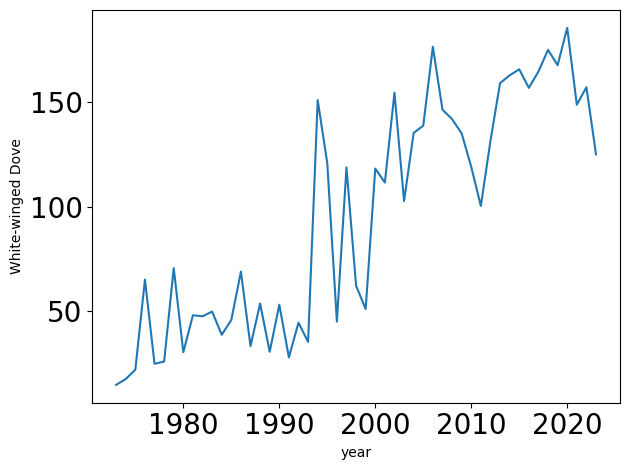

In [532]:
# to look at the data, I'll use pyplot and seaborn
import matplotlib.pyplot as plt
import seaborn as sns 

# Let's make a line graph for each species and the polygon area over time.
sns.lineplot(PolygonYearGraph["White-winged Dove"])
plt.tight_layout()
plt.show()

In [231]:
#  augmented Dickey-Fuller test from the statsmodels package for time series analysis of these data!
from statsmodels.tsa.stattools import adfuller

In [252]:
# for each species, produce a time series to check whether the data is stationary.
Dickey_Fuller = adfuller(PolygonYearGraph["American Redstart"].values.tolist(),autolag="AIC")

In [256]:
output_amre_dfts = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_amre_dfts)

      Values                       Metric
0  -1.138609              Test Statistics
1   0.699432                      p-value
2   3.000000             No. of lags used
3  47.000000  Number of observations used
4  -3.577848          critical value (1%)
5  -2.925338          critical value (5%)
6  -2.600774         critical value (10%)


In [257]:
Dickey_Fuller = adfuller(PolygonYearGraph["White-winged Dove"].values.tolist(),autolag="AIC")
output_wwdo_dfts = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_wwdo_dfts)

      Values                       Metric
0  -1.764632              Test Statistics
1   0.398157                      p-value
2   1.000000             No. of lags used
3  49.000000  Number of observations used
4  -3.571472          critical value (1%)
5  -2.922629          critical value (5%)
6  -2.599336         critical value (10%)


In [259]:
Dickey_Fuller = adfuller(PolygonYearGraph["Black-throated Sparrow"].values.tolist(),autolag="AIC")
output_btsp_dfts = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_btsp_dfts)

      Values                       Metric
0  -0.701363              Test Statistics
1   0.846396                      p-value
2  11.000000             No. of lags used
3  39.000000  Number of observations used
4  -3.610400          critical value (1%)
5  -2.939109          critical value (5%)
6  -2.608063         critical value (10%)


In [549]:
Dickey_Fuller = adfuller(PolygonYearGraph["American Tree Sparrow"].values.tolist(),autolag="AIC")
output_atsp_dfts = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_atsp_dfts)

      Values                       Metric
0  -0.336838              Test Statistics
1   0.920122                      p-value
2   4.000000             No. of lags used
3  46.000000  Number of observations used
4  -3.581258          critical value (1%)
5  -2.926785          critical value (5%)
6  -2.601541         critical value (10%)


In [276]:
# let's limit the data to the last 10 years and compare results.
TimeSeriesTenYears = PolygonYearGraph.tail(10)
#pd.DataFrame(PolygonYearTimeSeries['2023'])          #["2023","2022","2021","2020","2019","2018","2017","2016","2015","2014"]
TimeSeriesTenYears.head(10)

common_name,American Redstart,American Robin,American Tree Sparrow,Barn Swallow,Black-chinned Hummingbird,Black-throated Sparrow,Broad-billed Hummingbird,Calliope Hummingbird,Chipping Sparrow,Common Nighthawk,...,Vaux's Swift,Veery,Virginia's Warbler,Western Bluebird,Western Wood-Pewee,White-throated Swift,White-winged Dove,Wilson's Warbler,Yellow Warbler,Yellow-rumped Warbler
year,,,,,,,,,,,,,,,,,,,,,
2014,328.197443,386.993354,318.489874,412.696109,218.446244,150.638629,16.827366,296.607264,383.608051,336.693671,...,275.860229,125.809748,112.951850,220.389850,360.021731,223.139856,162.971009,390.719218,394.878434,405.265577
2015,337.759105,395.096552,333.085211,396.096570,224.571595,158.643366,30.655339,270.912378,380.007545,304.468001,...,295.514805,94.916773,108.879709,229.333222,389.569062,221.714268,165.887657,391.688492,397.671411,400.577742
2016,338.110870,403.569028,340.259821,393.653892,210.491259,179.533627,25.270560,283.807349,363.853198,332.567323,...,288.570843,111.795121,134.159884,227.680435,351.308676,221.879417,156.986134,391.223948,411.663926,390.184149
2017,348.075453,400.372374,336.645467,401.537206,220.521501,136.948724,61.484057,251.723924,397.658398,338.705844,...,287.357556,112.857952,156.379341,226.495724,369.162983,226.465744,164.762317,395.540515,402.072468,401.553130
2018,368.131195,404.092450,350.866763,401.494006,220.223727,167.580112,45.618830,275.344553,401.490948,332.420194,...,282.469563,111.478816,151.434546,230.286492,366.195359,229.217129,175.212809,394.410453,403.644365,405.182589
2019,395.653071,400.797451,346.881802,408.759980,221.383856,171.686554,64.799011,253.582937,372.097957,341.169207,...,283.298615,108.887369,113.160530,229.997501,378.336356,232.190831,167.859268,410.111839,398.270003,423.440502
2020,352.466573,397.531003,355.874573,397.003004,218.133286,193.892735,73.663922,274.802741,400.445054,314.867653,...,299.976928,151.259365,128.901461,229.017441,361.389698,225.972488,185.752769,397.405971,400.182832,400.996699
2021,336.882674,397.418039,351.634079,399.205301,223.338213,191.010919,38.352989,279.153811,401.539521,336.226578,...,285.625197,111.432861,131.137260,214.330947,366.429146,221.914047,148.897482,395.298354,397.617275,399.640813
2022,367.310131,395.081481,350.822670,393.399716,222.541032,154.329660,26.716942,275.862844,386.474632,345.259964,...,298.948480,144.861279,158.006332,229.615632,385.577523,228.121149,157.292957,389.394704,398.343138,408.808114


In [272]:
Dickey_Fuller = adfuller(TimeSeriesTenYears["White-winged Dove"].values.tolist(),autolag="AIC")
output_wwdo_dfts_10 = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_wwdo_dfts_10)

     Values                       Metric
0 -3.343689              Test Statistics
1  0.013035                      p-value
2  3.000000             No. of lags used
3  6.000000  Number of observations used
4 -5.354256          critical value (1%)
5 -3.646238          critical value (5%)
6 -2.901198         critical value (10%)


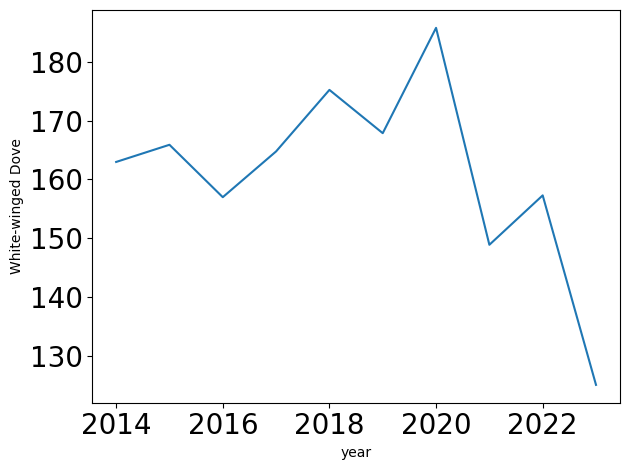

In [531]:
# That's quite different outcome from full data set. Let's visualize the last 10 years for this species.
sns.lineplot(TimeSeriesTenYears["White-winged Dove"])
plt.tight_layout()
plt.show()

In [275]:
# that polygon area seems to decrease quite a lot at the end. Let's limit the data to the last 5 years.
TimeSeriesFiveYears = PolygonYearGraph.tail(5)
TimeSeriesFiveYears.head(5)

common_name,American Redstart,American Robin,American Tree Sparrow,Barn Swallow,Black-chinned Hummingbird,Black-throated Sparrow,Broad-billed Hummingbird,Calliope Hummingbird,Chipping Sparrow,Common Nighthawk,...,Vaux's Swift,Veery,Virginia's Warbler,Western Bluebird,Western Wood-Pewee,White-throated Swift,White-winged Dove,Wilson's Warbler,Yellow Warbler,Yellow-rumped Warbler
year,,,,,,,,,,,,,,,,,,,,,
2019,395.653071,400.797451,346.881802,408.759980,221.383856,171.686554,64.799011,253.582937,372.097957,341.169207,...,283.298615,108.887369,113.160530,229.997501,378.336356,232.190831,167.859268,410.111839,398.270003,423.440502
2020,352.466573,397.531003,355.874573,397.003004,218.133286,193.892735,73.663922,274.802741,400.445054,314.867653,...,299.976928,151.259365,128.901461,229.017441,361.389698,225.972488,185.752769,397.405971,400.182832,400.996699
2021,336.882674,397.418039,351.634079,399.205301,223.338213,191.010919,38.352989,279.153811,401.539521,336.226578,...,285.625197,111.432861,131.137260,214.330947,366.429146,221.914047,148.897482,395.298354,397.617275,399.640813
2022,367.310131,395.081481,350.822670,393.399716,222.541032,154.329660,26.716942,275.862844,386.474632,345.259964,...,298.948480,144.861279,158.006332,229.615632,385.577523,228.121149,157.292957,389.394704,398.343138,408.808114
2023,357.307791,402.031550,322.153934,399.703728,221.253910,177.750181,39.010563,279.615132,406.180680,364.048679,...,331.329445,106.376722,157.346745,221.106133,373.983791,224.508643,125.099357,413.548564,402.023414,419.034080


In [277]:
Dickey_Fuller = adfuller(TimeSeriesFiveYears["White-winged Dove"].values.tolist(),autolag="AIC")
output_wwdo_dfts_05 = pd.DataFrame({"Values":[Dickey_Fuller[0],Dickey_Fuller[1],Dickey_Fuller[2],Dickey_Fuller[3], Dickey_Fuller[4]['1%'], 
                                    Dickey_Fuller[4]['5%'], Dickey_Fuller[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_wwdo_dfts_05)

     Values                       Metric
0 -0.720487              Test Statistics
1  0.841371                      p-value
2  0.000000             No. of lags used
3  4.000000  Number of observations used
4 -7.355441          critical value (1%)
5 -4.474365          critical value (5%)
6 -3.126933         critical value (10%)


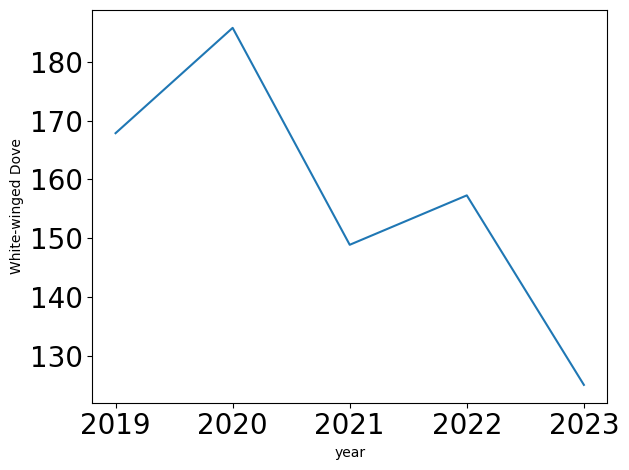

In [530]:
# amazing. Now the pattern is significant in a downward trend. This analysis is very sensitive to the amount of time sampled.
# let's visualize the last 5 years for this species.
sns.lineplot(TimeSeriesFiveYears["White-winged Dove"])
plt.tight_layout()
plt.show()

This totally bears out what I thought. You really need to look at different lengths of time in time-series data, because with long-term datasets such as ebird, it can be hard to tease out recent declines in ranges of populations of birds. I'm sure this bears out with densities as well. Now, it will be interesting to look at the last 5 years of polygons for White-winged Dove graphically to actually see what is happening to the polygon shape, as the area contained within it certainly seems to be contracting recently. Keep in mind, that just because the range is decreasing, it doesn't mean that the population is declining (thought that is a pretty big red flag). Just as increasing range certainly doesn't mean that the population is increasing!

Let's look at the histograms for this table as we get ready to perform some machine learning to cluster these bird species together. Maybe the model will be able to detect species with recent declines and put them all together.

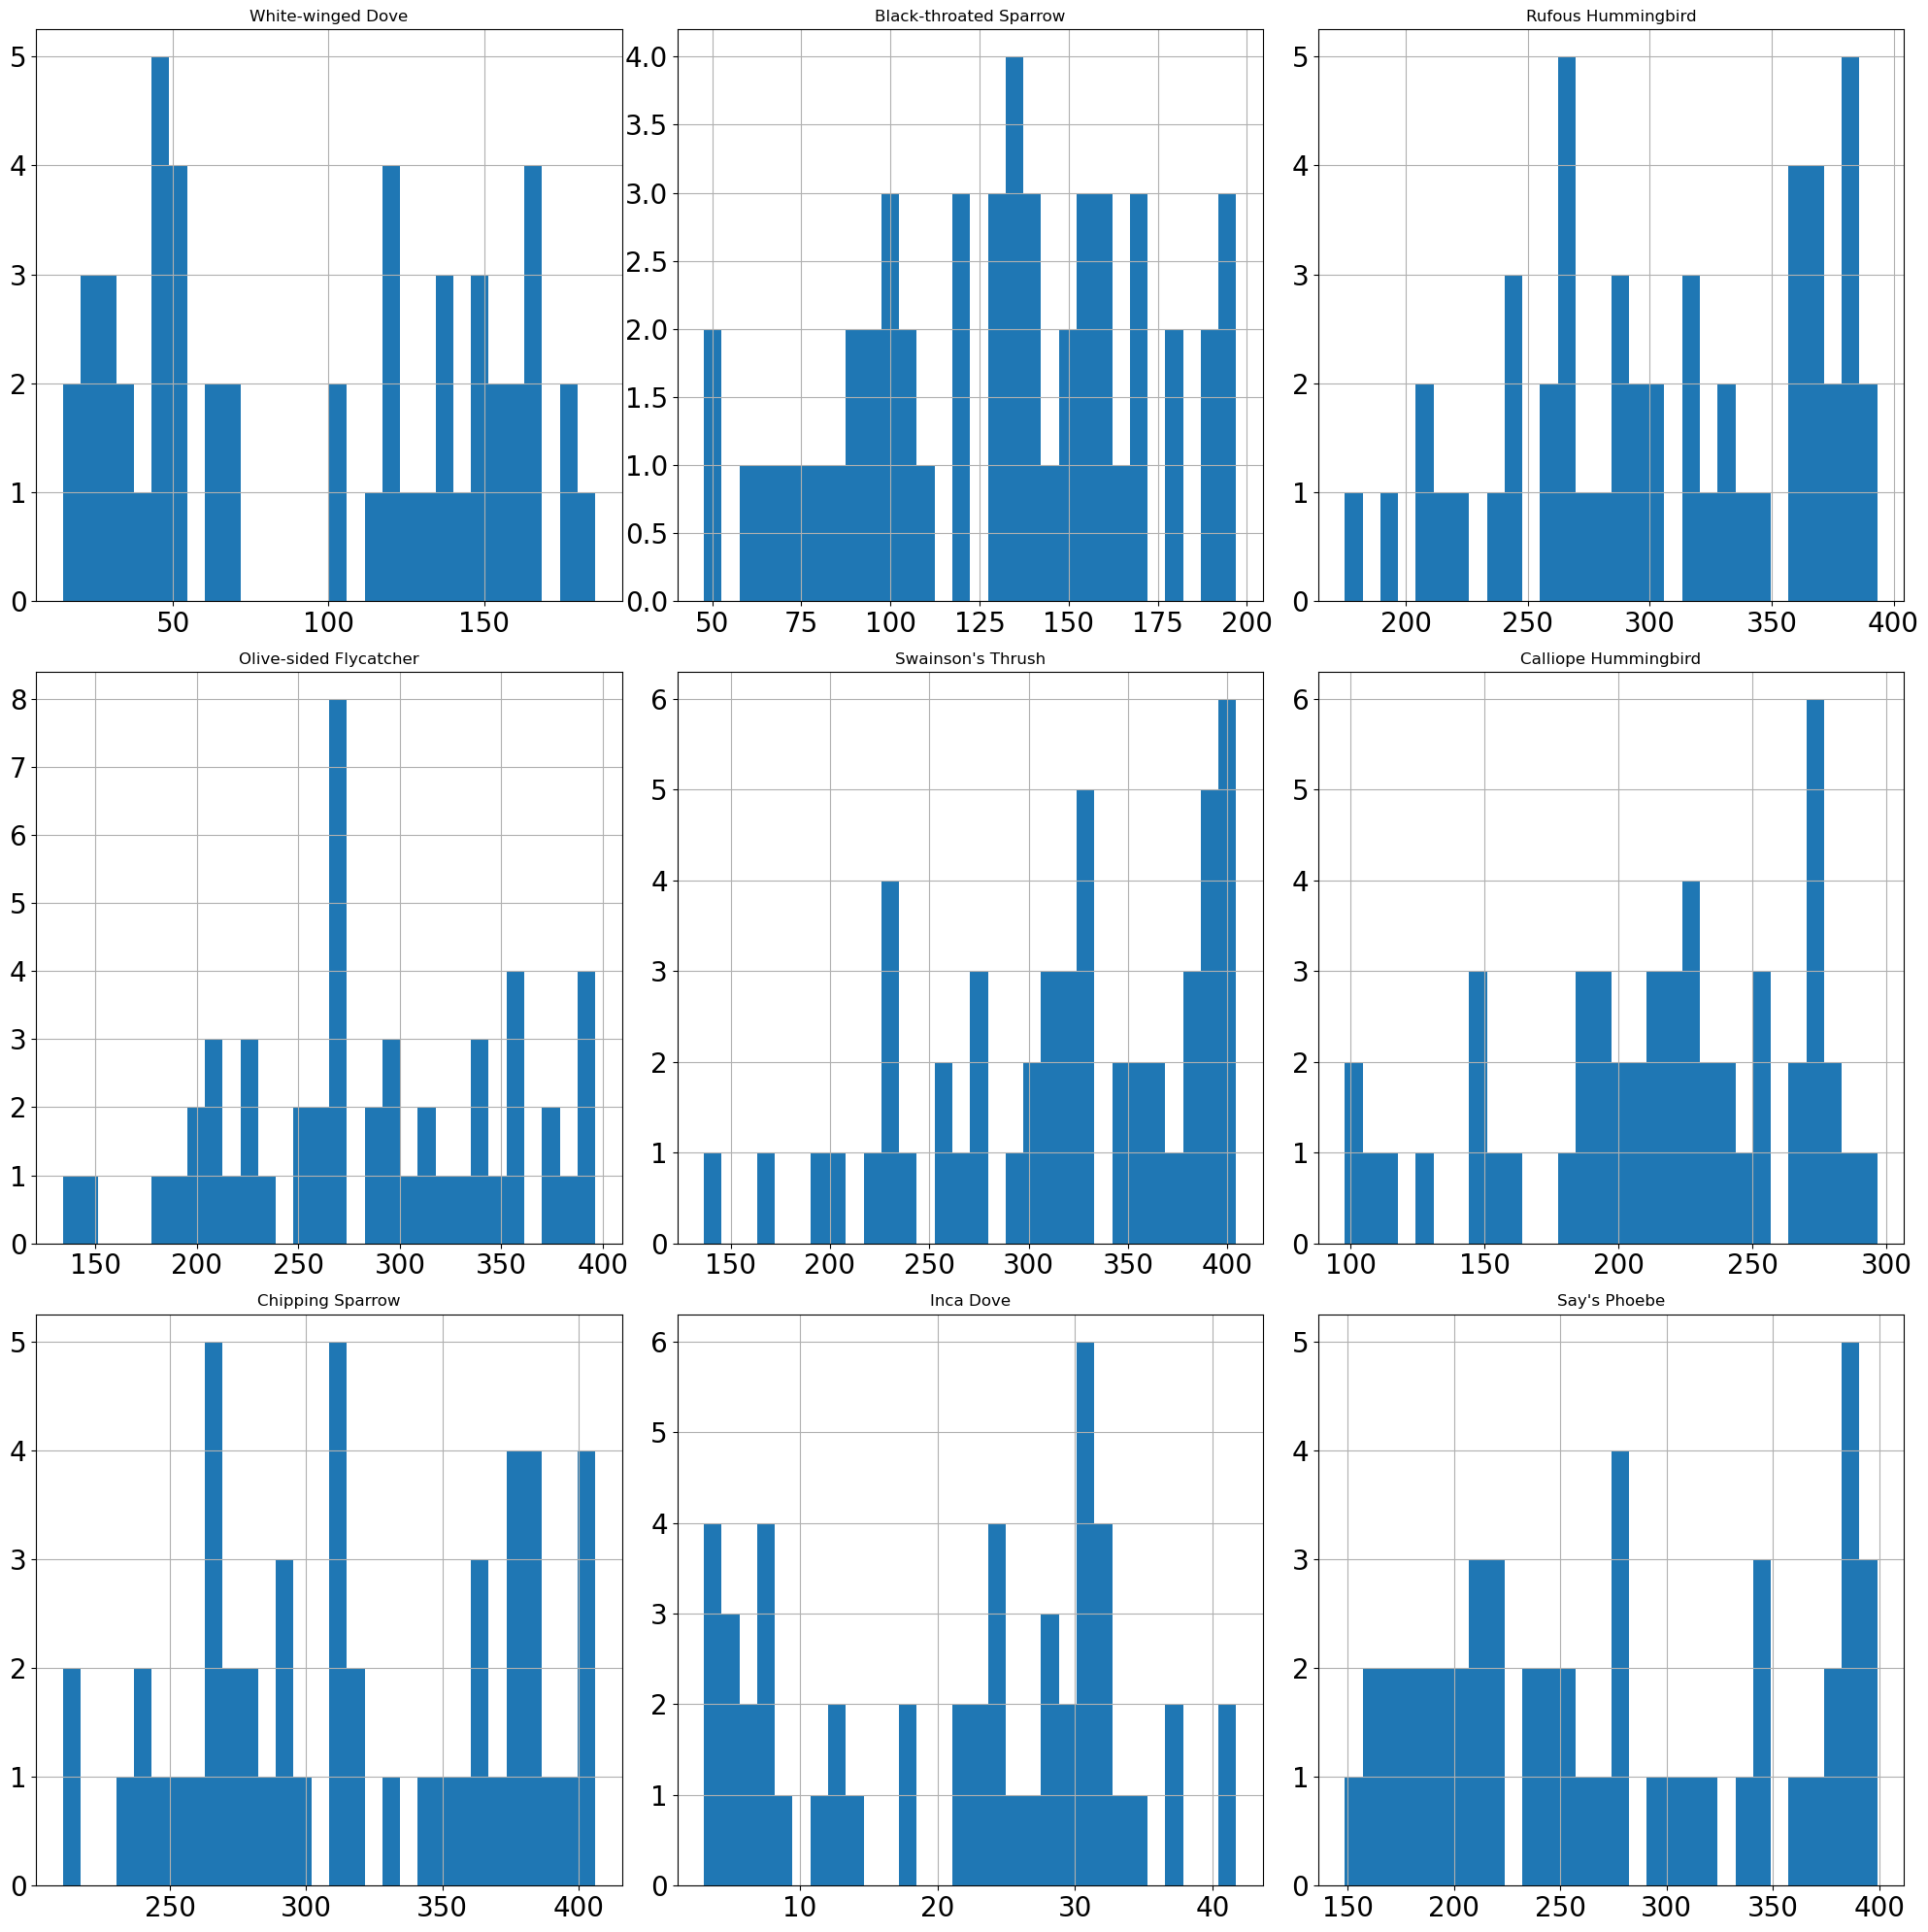

In [282]:
histogram = PolygonYearGraph[['White-winged Dove','Black-throated Sparrow','Rufous Hummingbird','Olive-sided Flycatcher',"Swainson's Thrush",
                              'Calliope Hummingbird','Chipping Sparrow','Inca Dove',"Say's Phoebe"]]
histogram.hist(bins=30,figsize=(20, 20))
plt.tight_layout()
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('figure', titlesize=20)
plt.show()
# plt.savefig('eda_histograms.png')

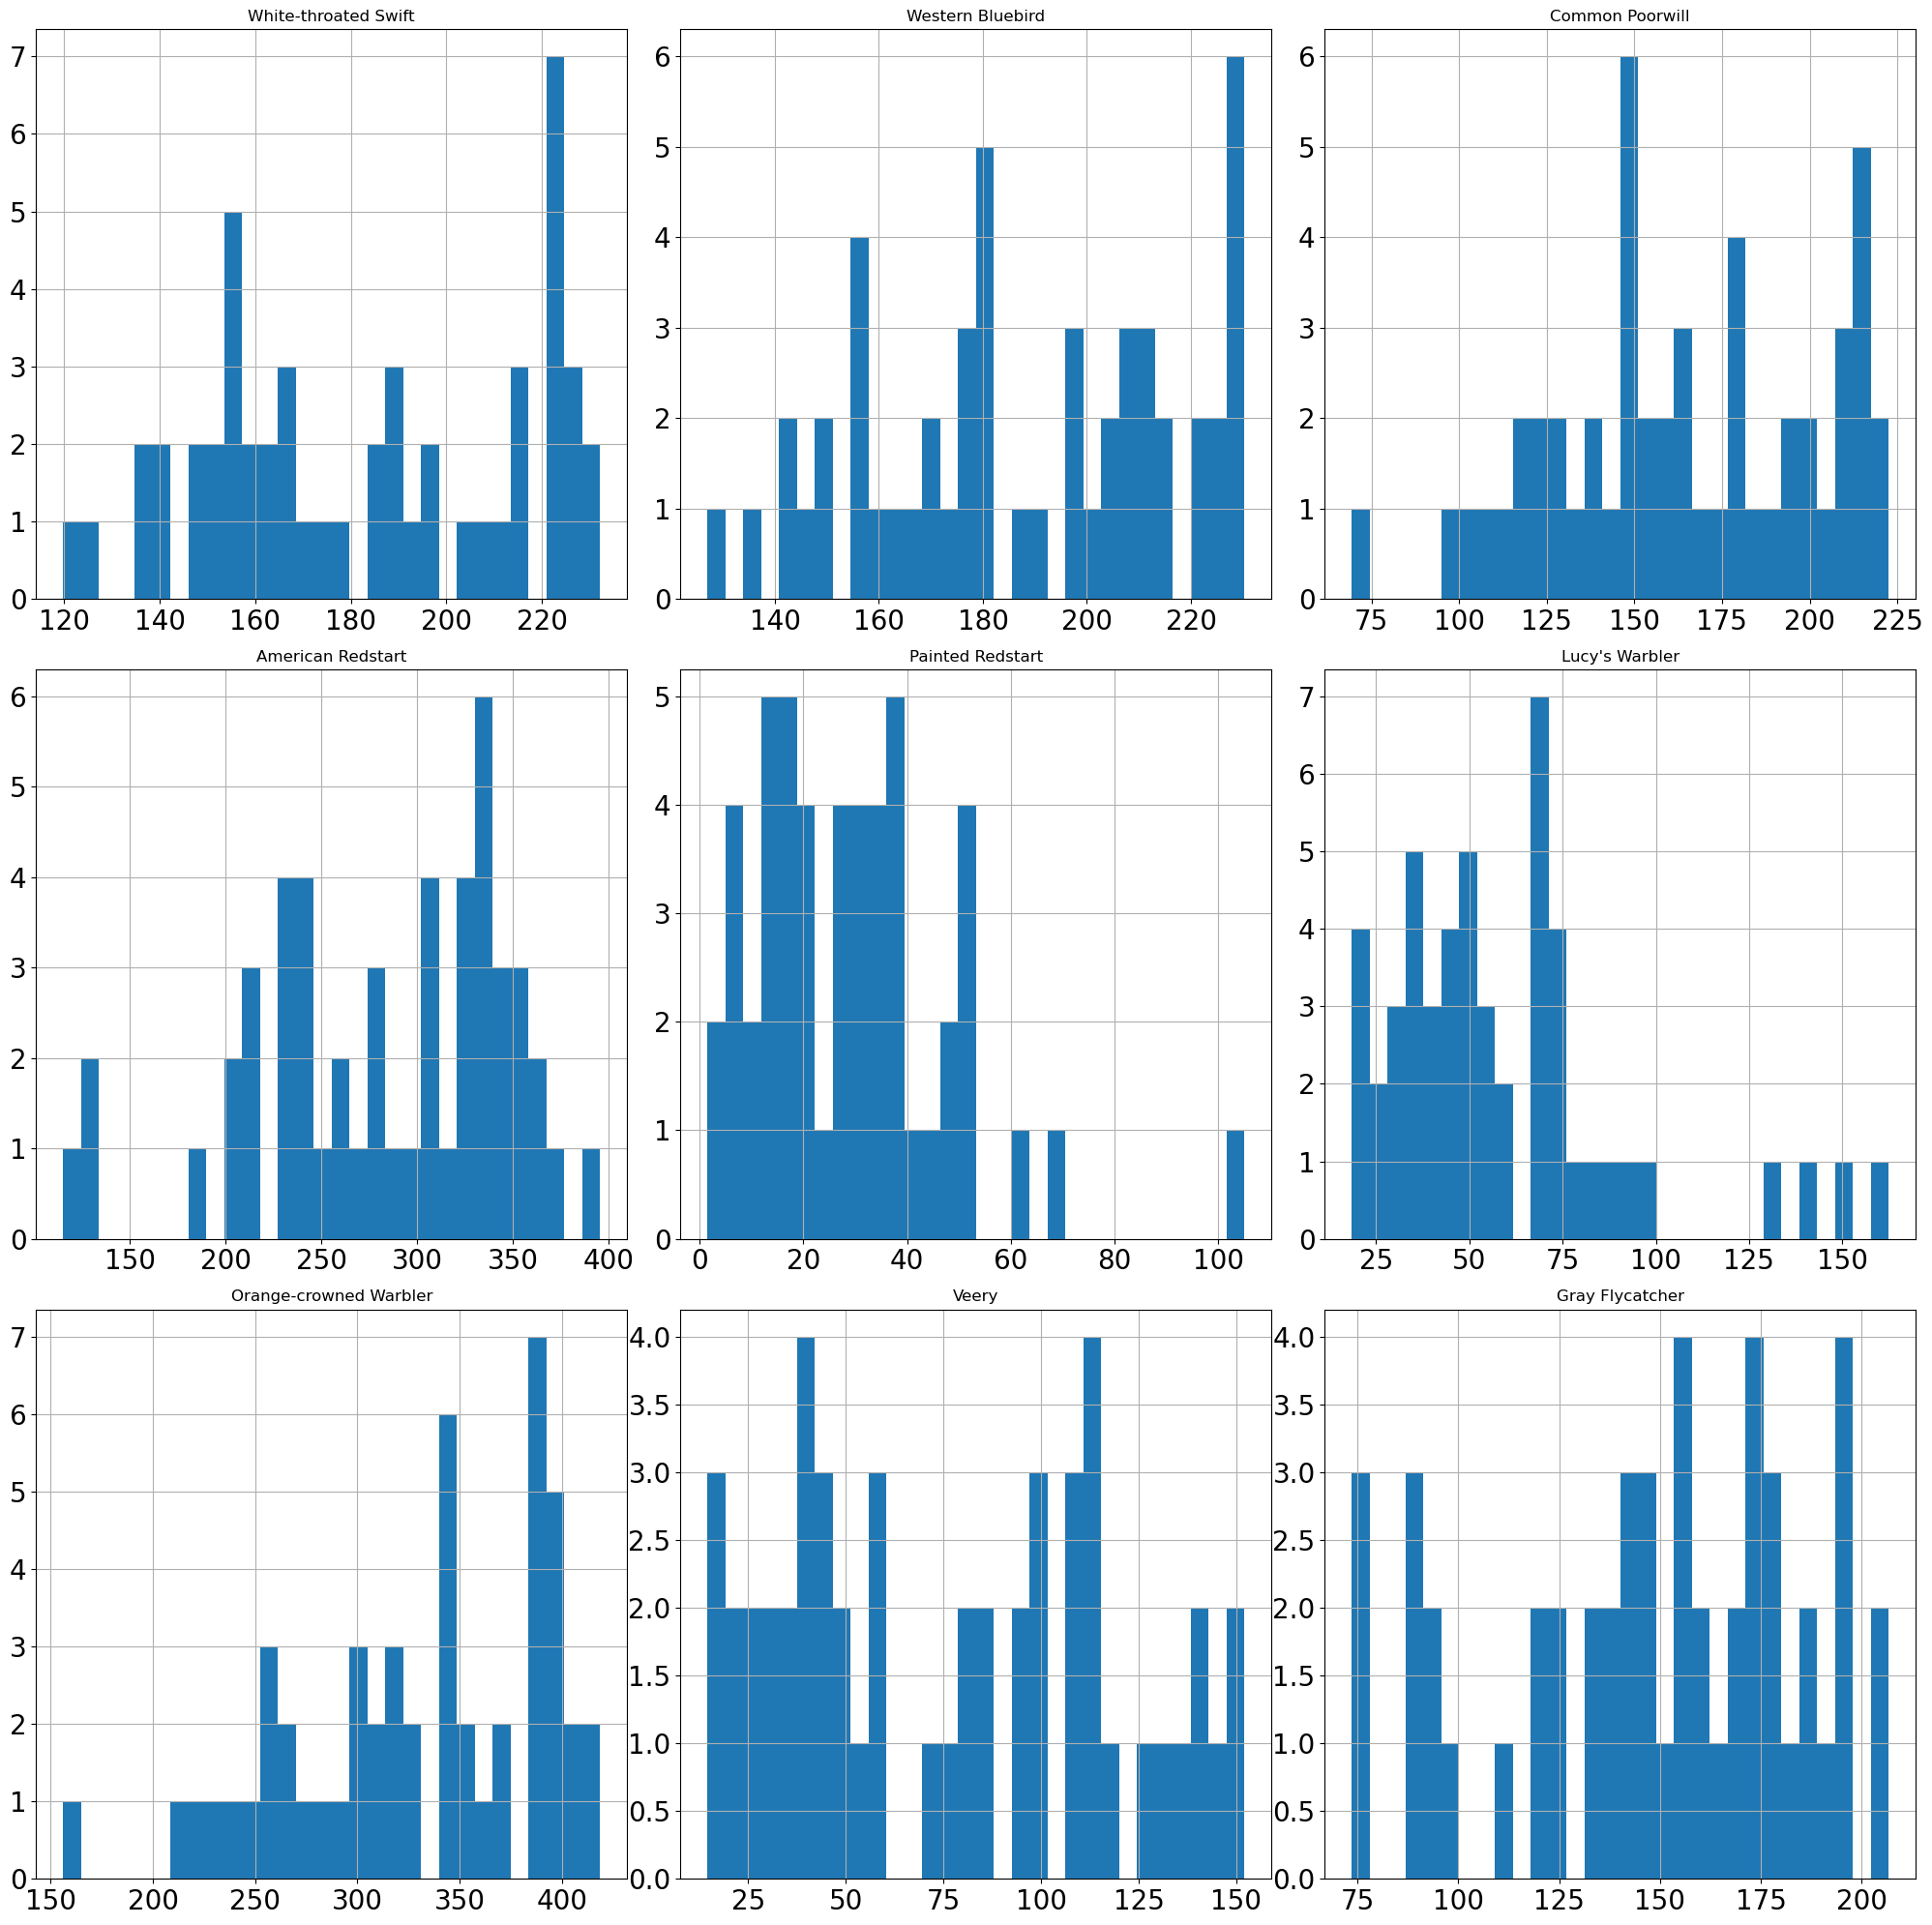

In [284]:
histogram2 = PolygonYearGraph[['White-throated Swift','Western Bluebird','Common Poorwill','American Redstart','Painted Redstart',"Lucy's Warbler",
                               'Orange-crowned Warbler','Veery','Gray Flycatcher',]]
histogram2.hist(bins=30,figsize=(20, 20))
plt.tight_layout()
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('figure', titlesize=20)
plt.show()

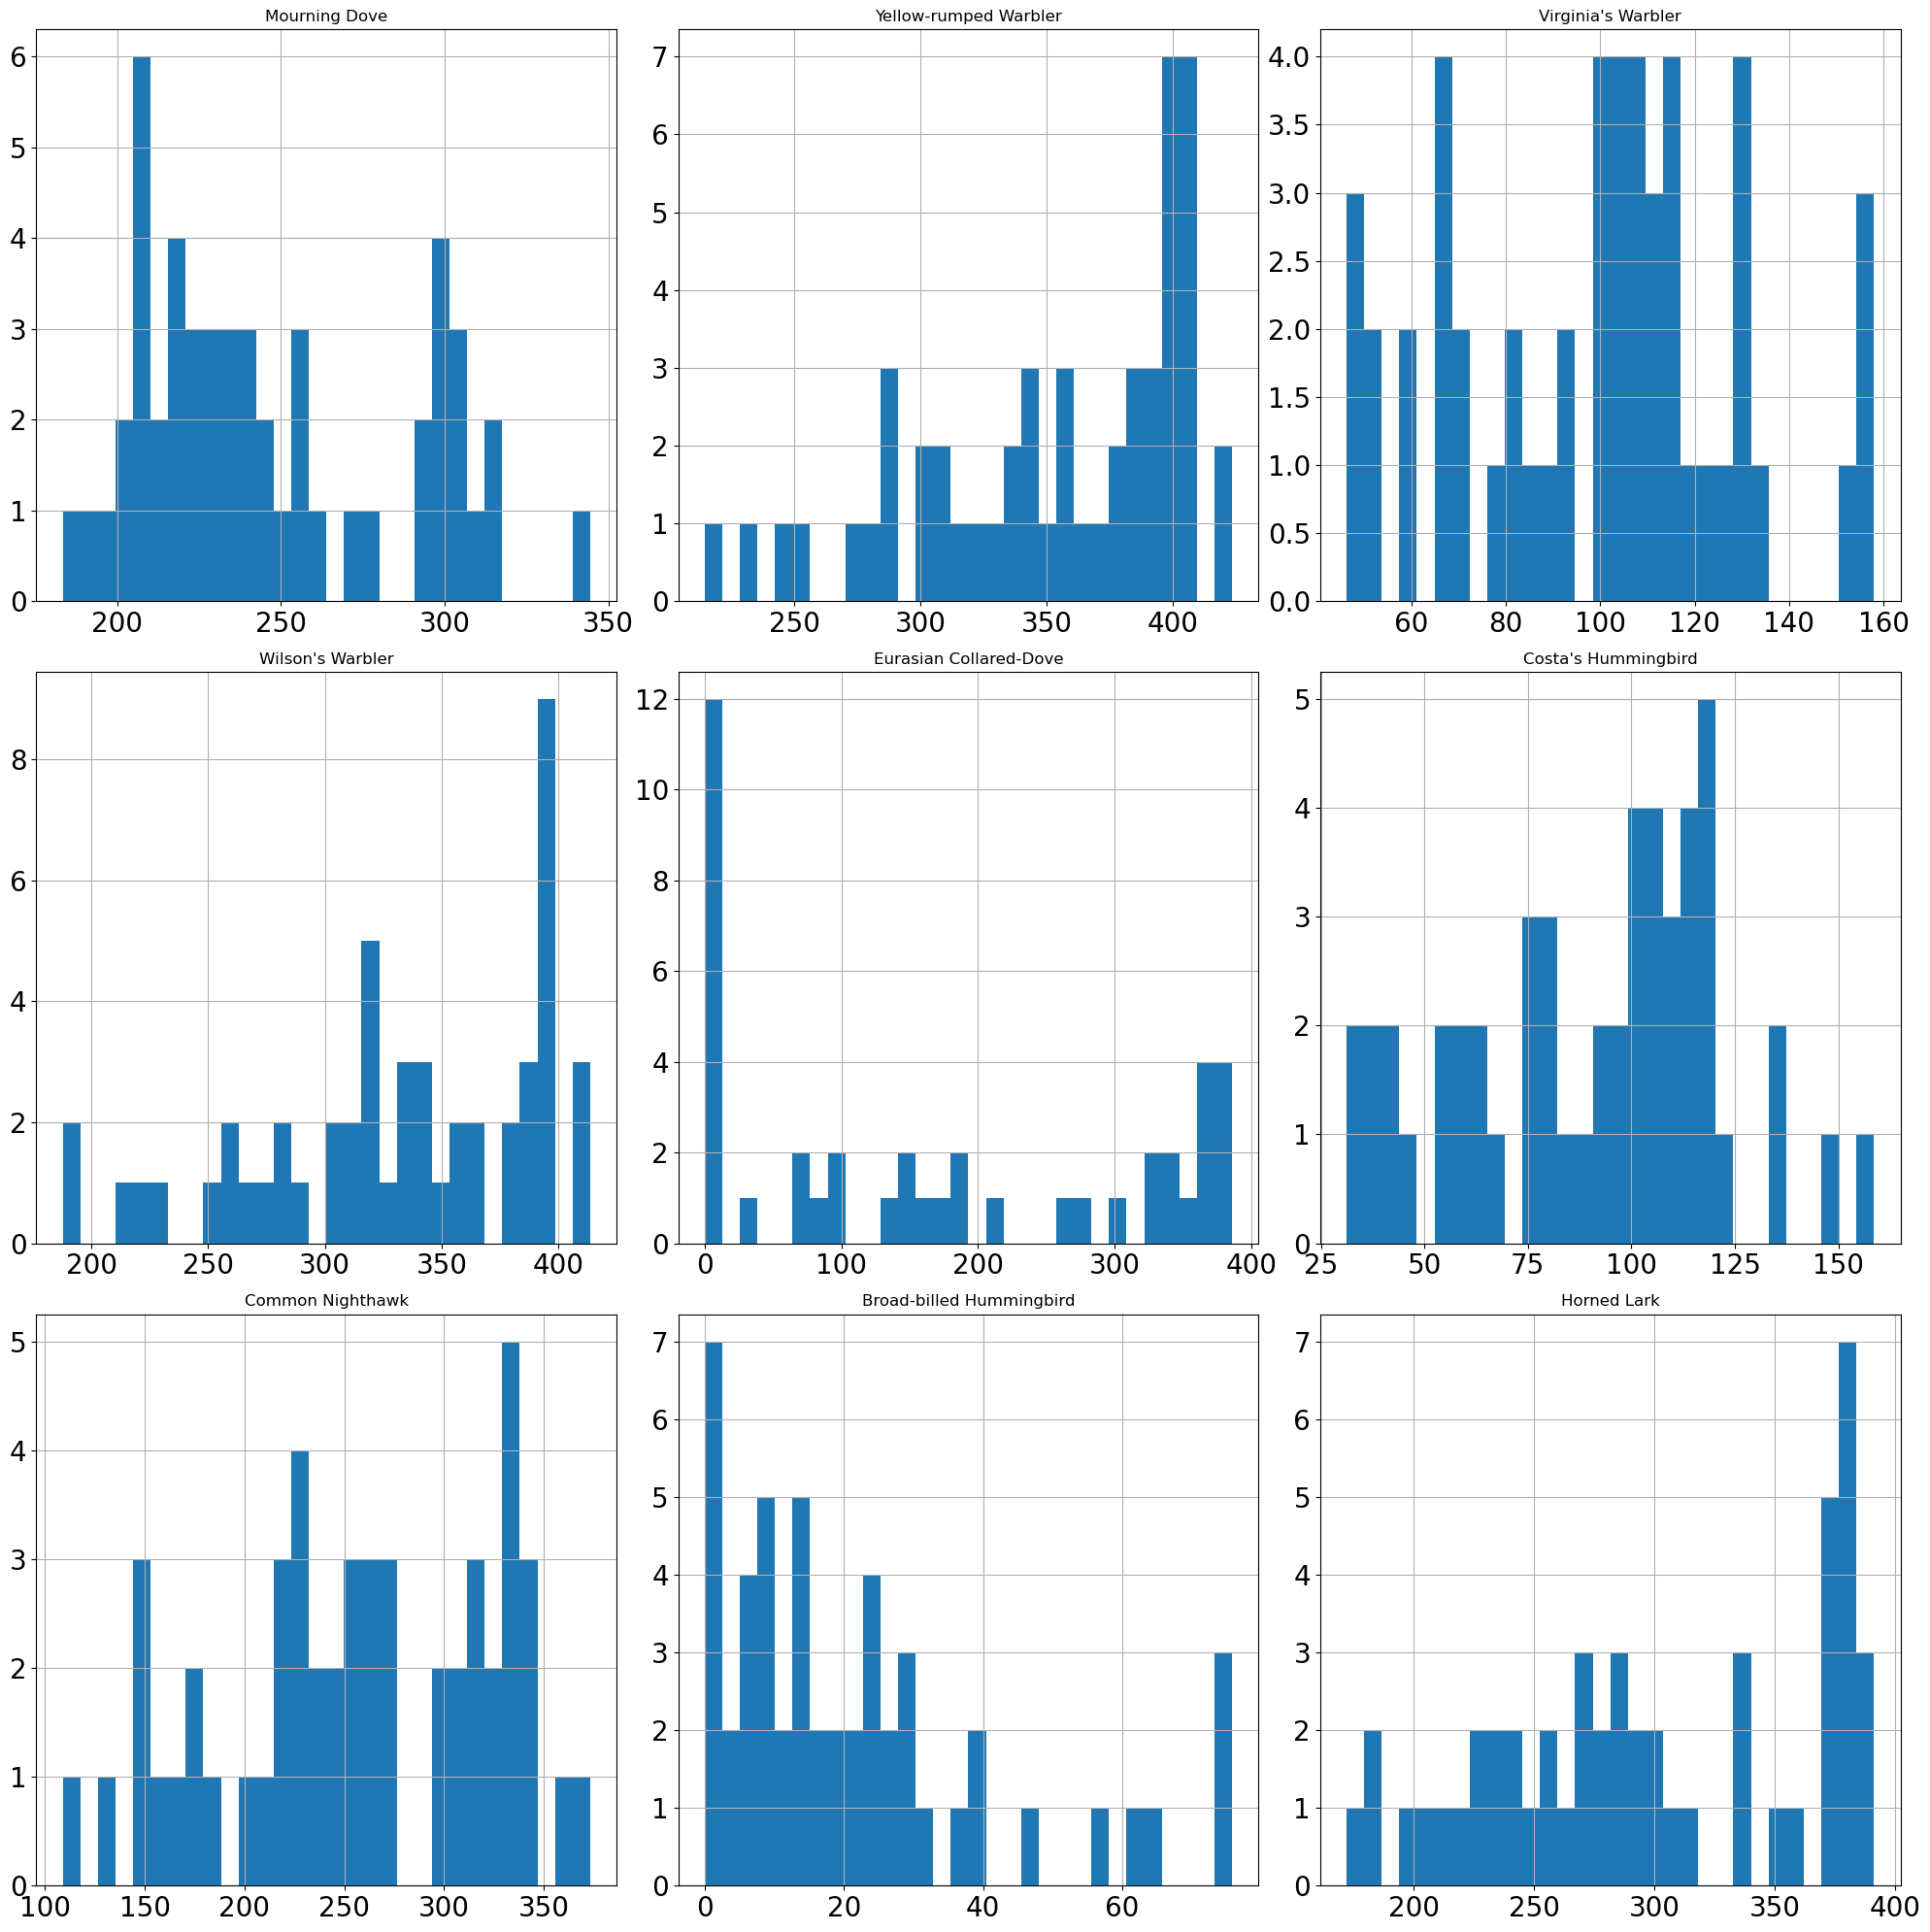

In [285]:
histogram3 = PolygonYearGraph[['Mourning Dove','Yellow-rumped Warbler',"Virginia's Warbler","Wilson's Warbler",'Eurasian Collared-Dove',
                               "Costa's Hummingbird",'Common Nighthawk','Broad-billed Hummingbird','Horned Lark',]]
histogram3.hist(bins=30,figsize=(20, 20))
plt.tight_layout()
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('figure', titlesize=20)
plt.show()

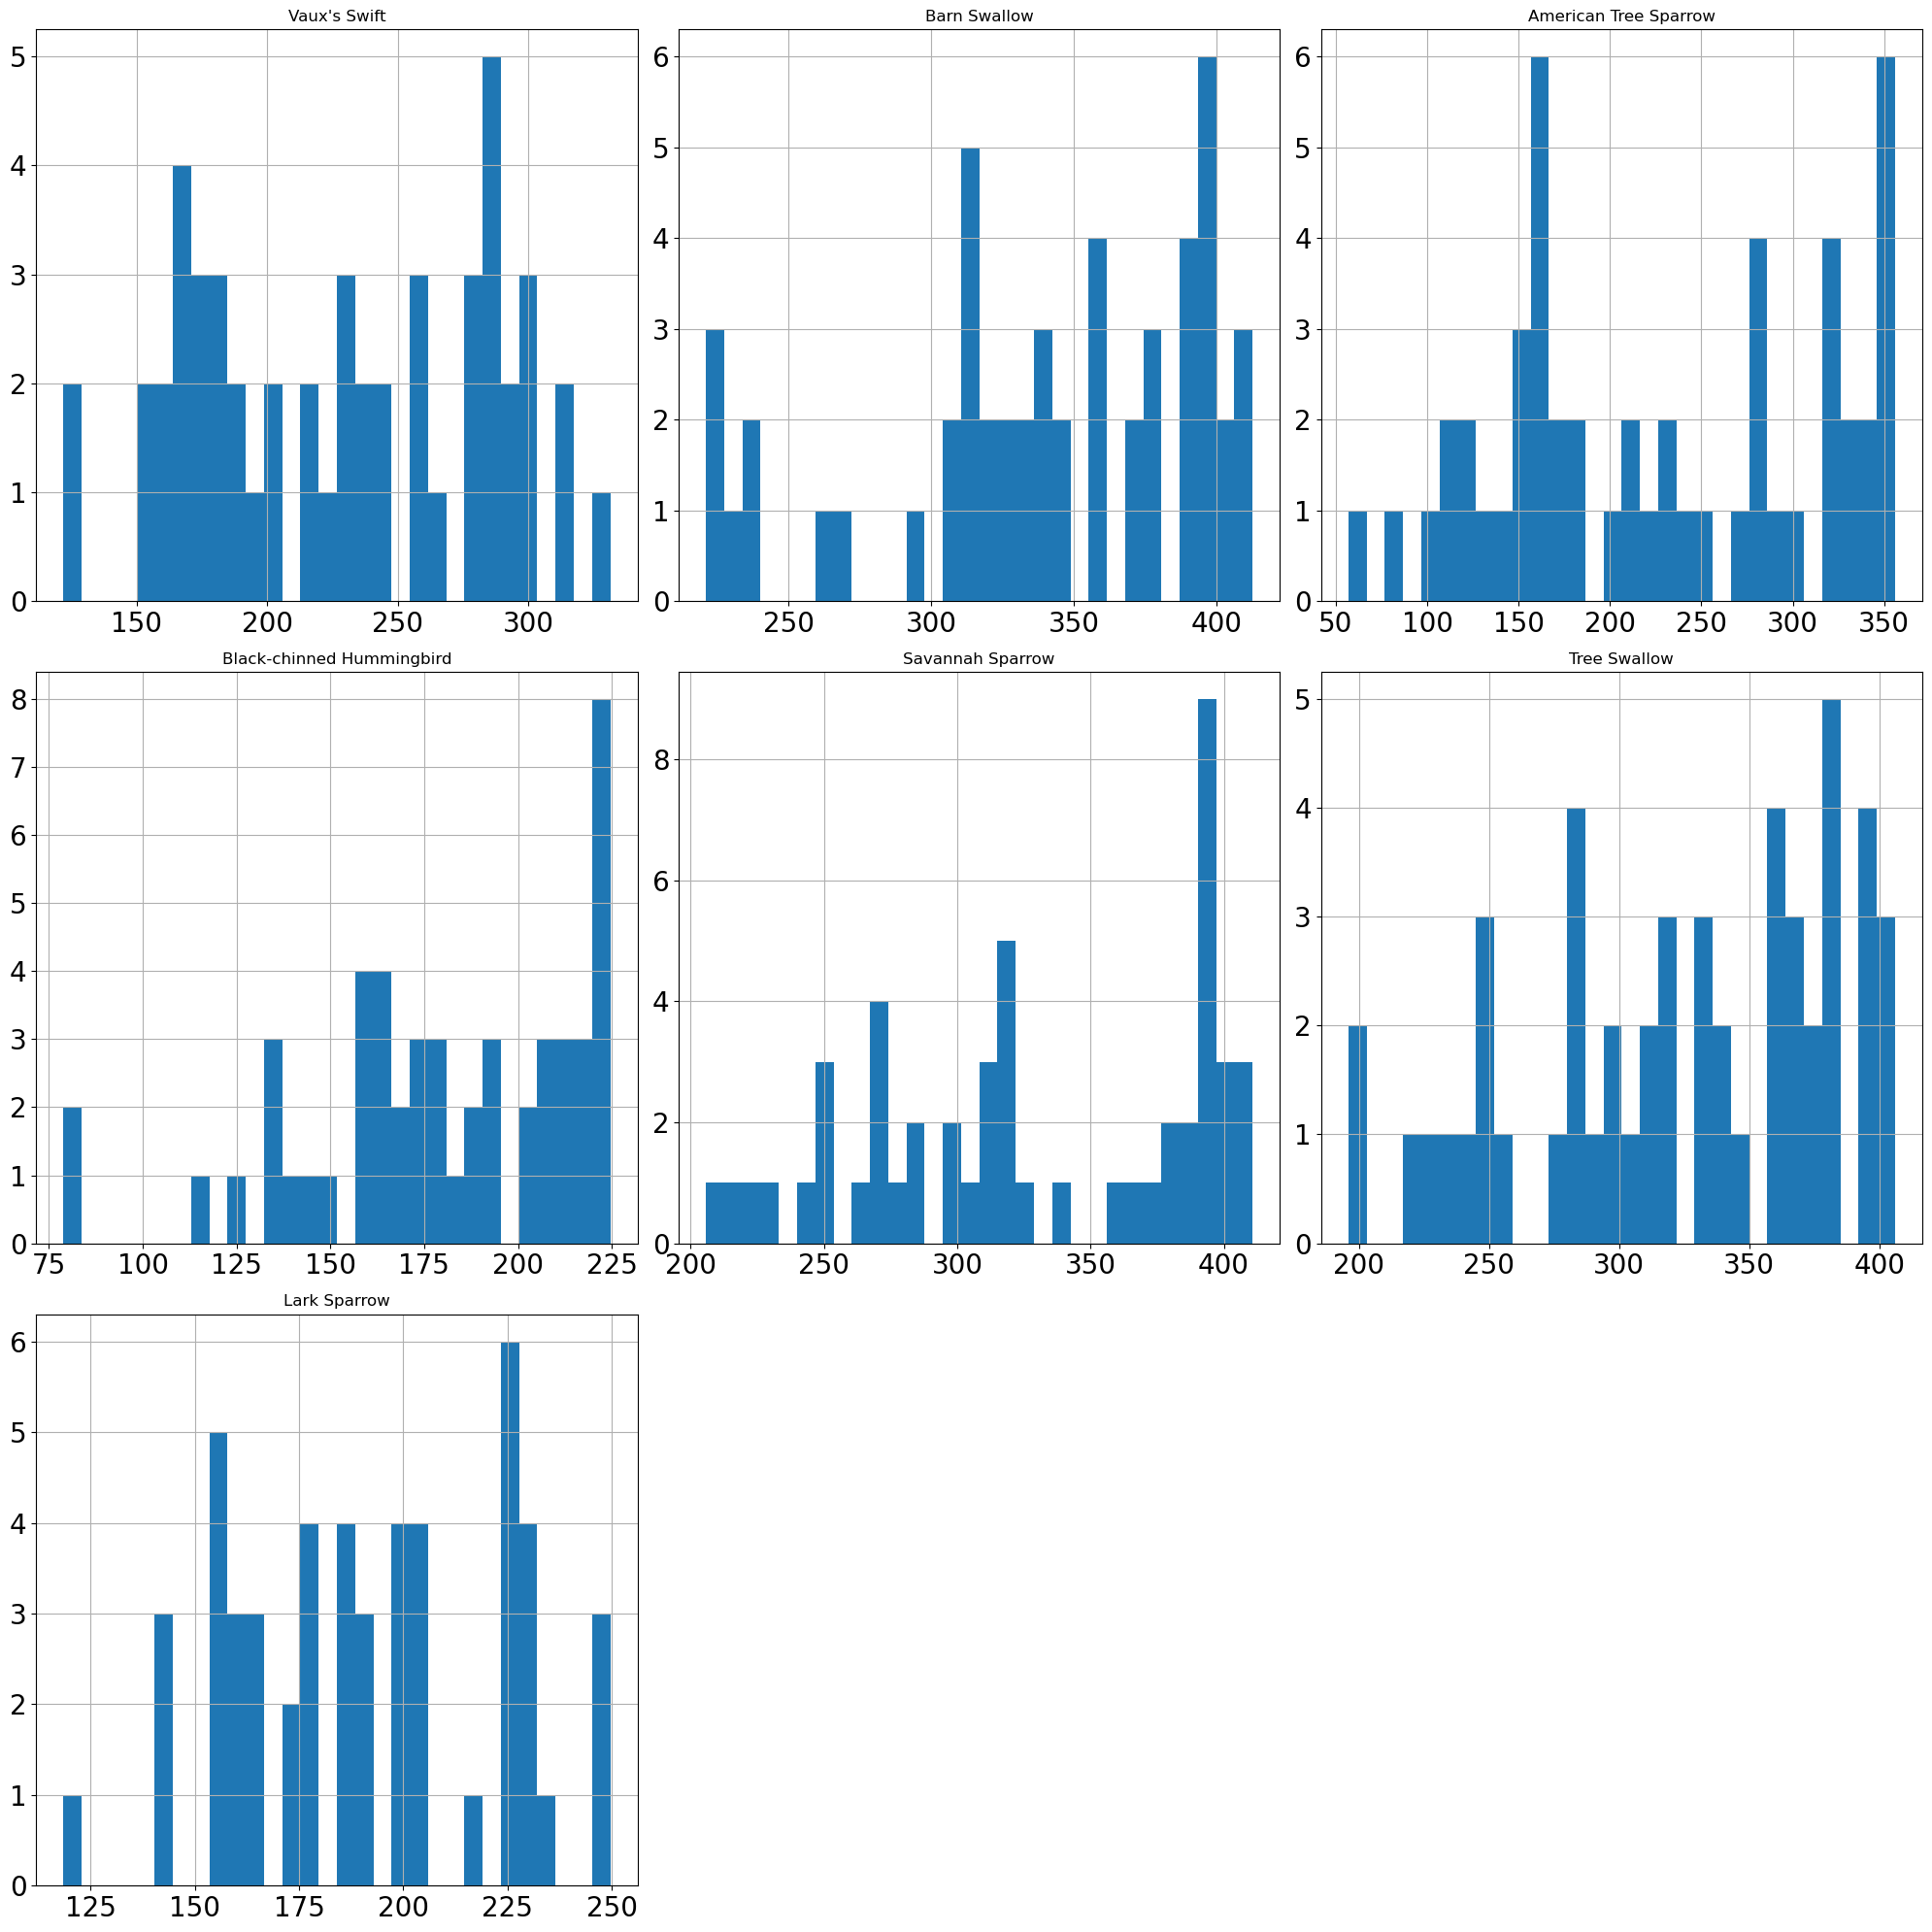

In [287]:
histogram4 = PolygonYearGraph[["Vaux's Swift",'Barn Swallow','American Tree Sparrow','Black-chinned Hummingbird','Savannah Sparrow','Tree Swallow',
                              'Lark Sparrow',]]
histogram4.hist(bins=30,figsize=(20, 20))
plt.tight_layout()
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('figure', titlesize=20)
plt.show()

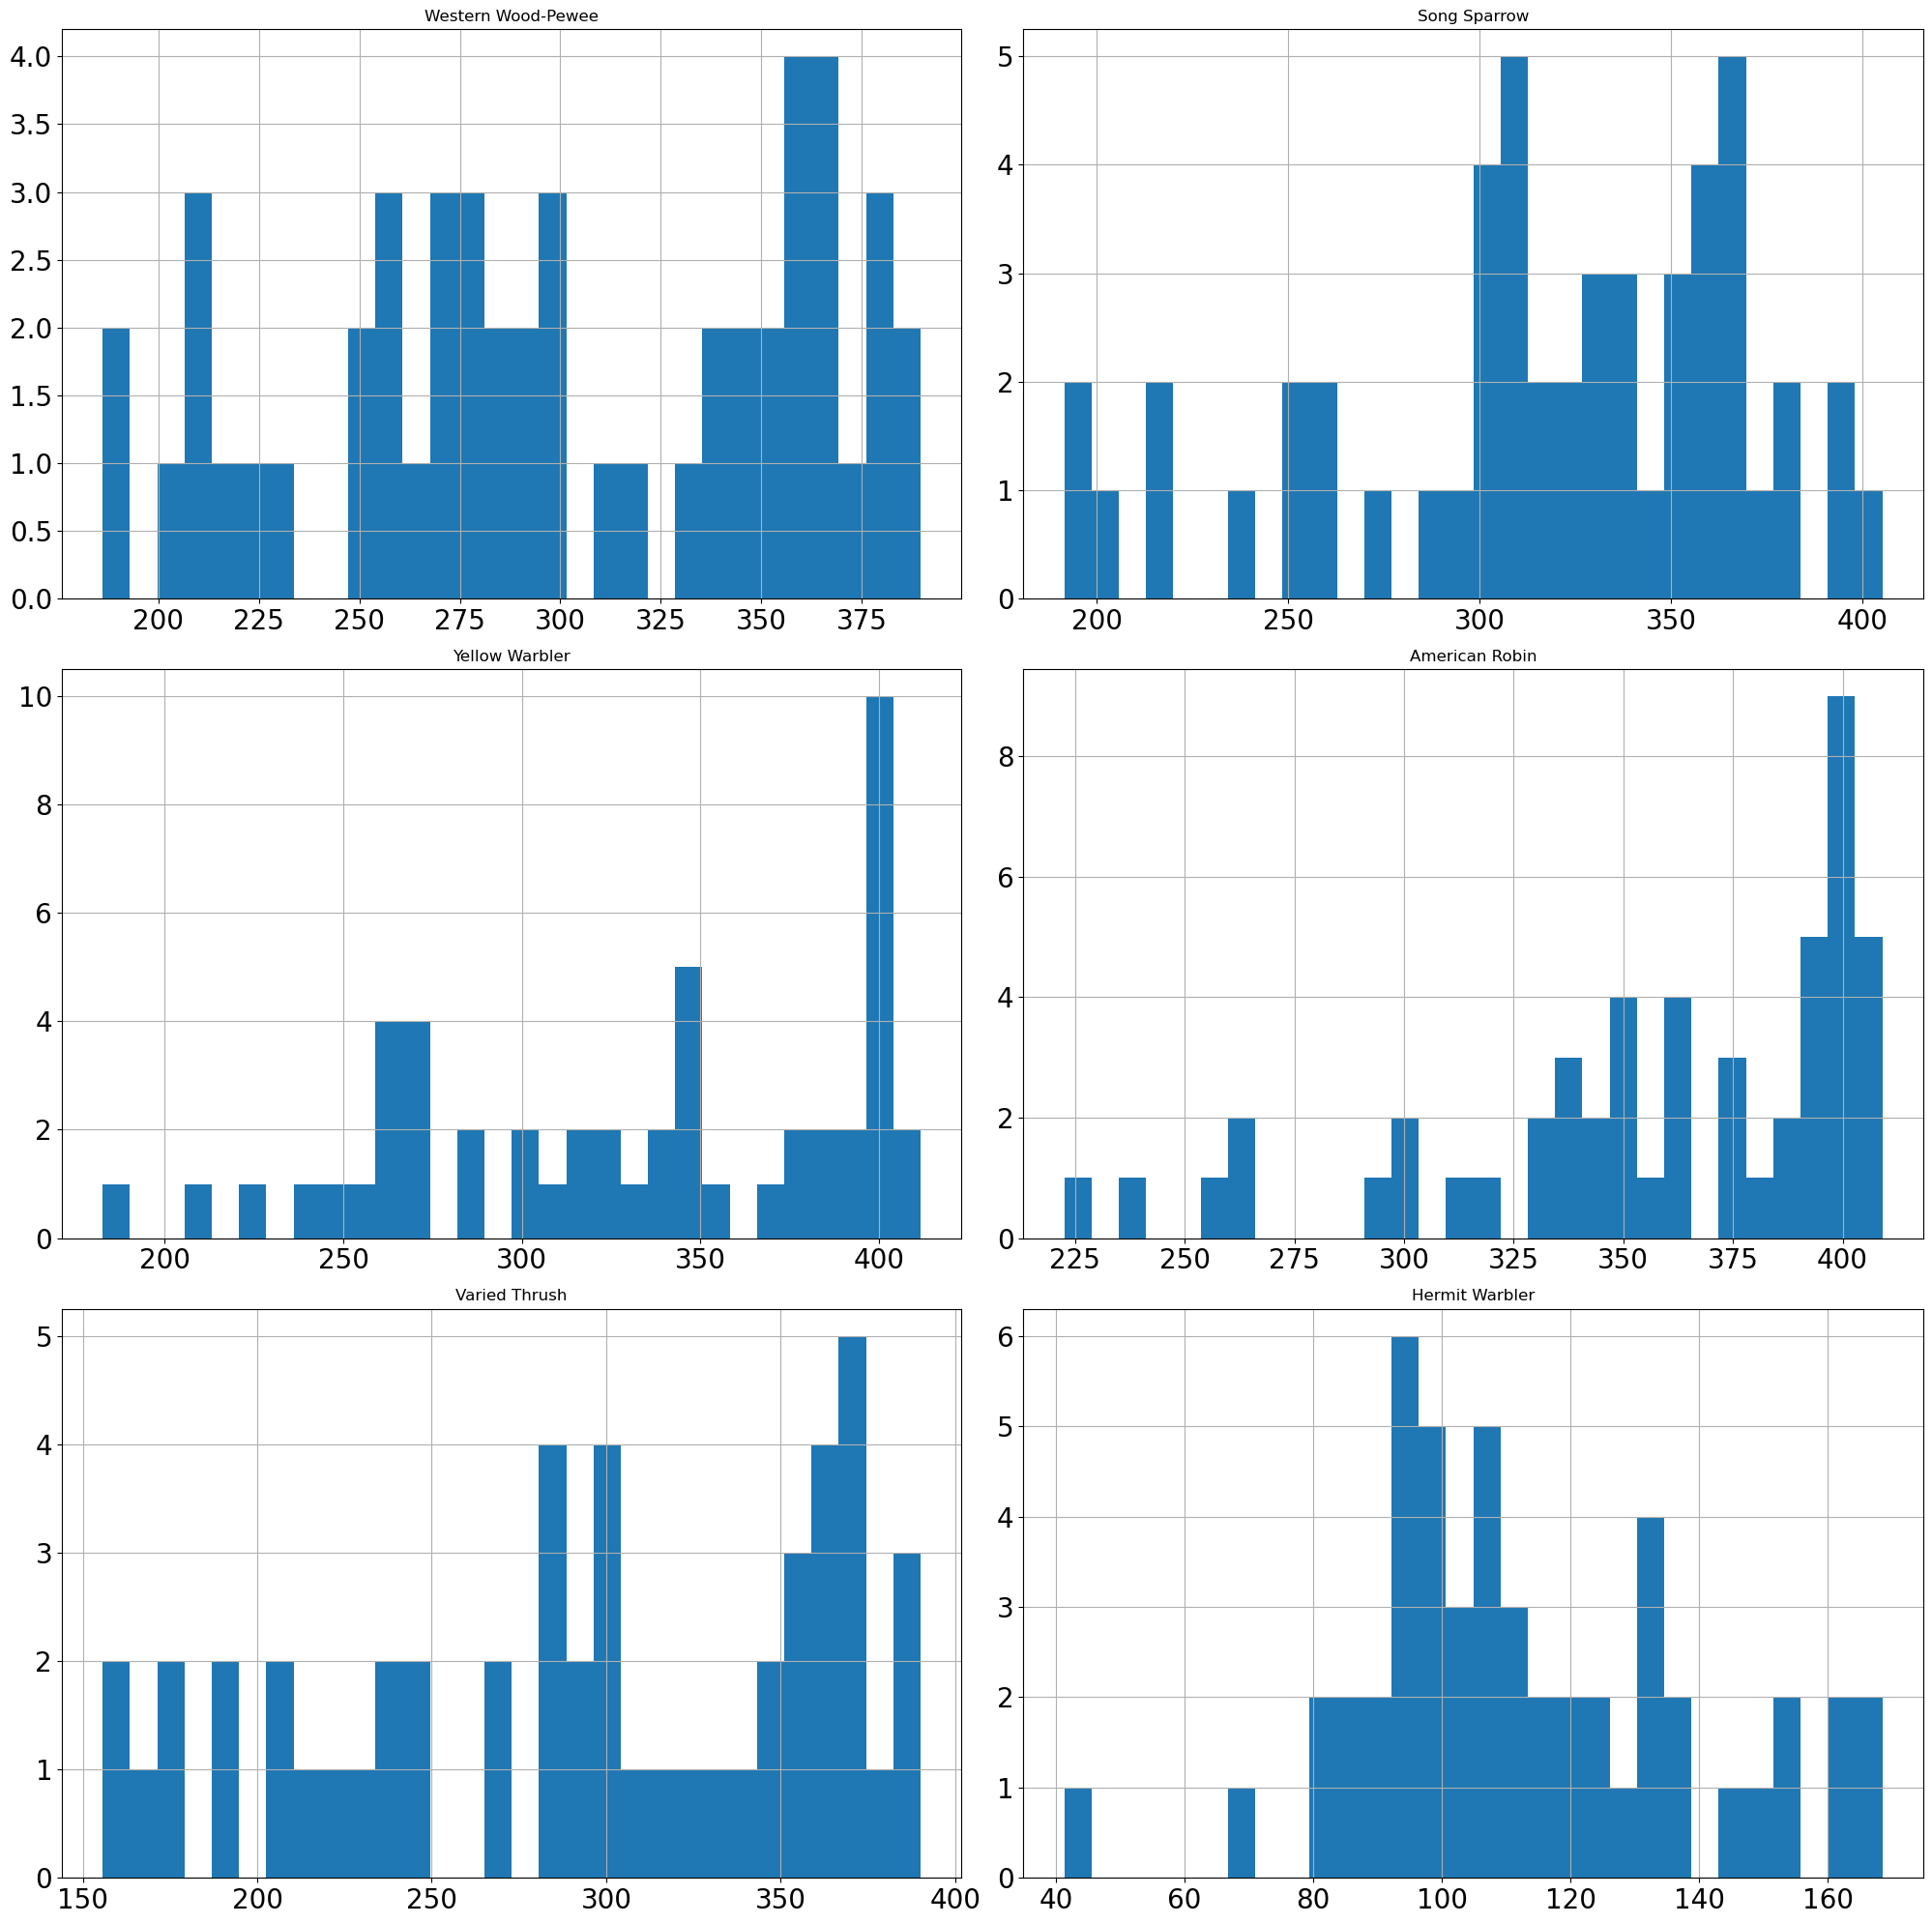

In [288]:
histogram5 = PolygonYearGraph[['Western Wood-Pewee','Song Sparrow','Yellow Warbler','American Robin','Varied Thrush','Hermit Warbler']]
histogram5.hist(bins=30,figsize=(20, 20))
plt.tight_layout()
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('figure', titlesize=20)
plt.show()

Now, I'm going to run a k-means cluster analysis on these data. Because I have even chunks of time represented, not samples made up of 'snapshots' of time that are not homogeneous, I don't have to worry about any fancy custom distance measurement. Euclidean distance should work just fine. However, because I don't want to cluster based on the size of the area, but the way area is changing over time, I want to change the values of the data from area within the polygon to some unit of change from one year to another. In this way, I will lose one year of data (the first 'change' takes 2 years), but I will end up with a measurement that should be comparable among all the species. This way, I will be clustering based on the change in the polygon shape over time, which is exactly what I want. 

In [289]:
# we have a good head start on this dataset. Recall:
PolygonYearTimeSeries.head(5)

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
common_name,,,,,,,,,,,,,,,,,,,,,
American Redstart,129.886093,302.289206,126.289002,216.786103,115.117135,205.398519,234.253657,231.216553,245.408476,182.469615,...,328.197443,337.759105,338.110870,348.075453,368.131195,395.653071,352.466573,336.882674,367.310131,357.307791
American Robin,235.026508,332.332345,297.769576,363.537287,222.551629,262.110009,351.244603,364.920917,260.570468,254.788562,...,386.993354,395.096552,403.569028,400.372374,404.092450,400.797451,397.531003,397.418039,395.081481,402.031550
American Tree Sparrow,158.408117,179.336399,319.071161,164.496778,153.082547,149.191688,242.234756,199.762190,56.895871,105.399831,...,318.489874,333.085211,340.259821,336.645467,350.866763,346.881802,355.874573,351.634079,350.822670,322.153934
Barn Swallow,221.589235,264.508121,221.118548,318.225467,224.956113,229.605150,312.558099,340.331330,268.308691,234.541690,...,412.696109,396.096570,393.653892,401.537206,401.494006,408.759980,397.003004,399.205301,393.399716,399.703728
Black-chinned Hummingbird,116.268879,78.902839,123.249152,136.641634,133.581550,133.566039,159.477559,163.413584,162.168597,83.421753,...,218.446244,224.571595,210.491259,220.521501,220.223727,221.383856,218.133286,223.338213,222.541032,221.253910


In [344]:
# I don't necessarily want to mess with that dataset, so I'll save a copy and rename it.
AreaYeardf = pd.DataFrame(PolygonYearTimeSeries)
AreaYeardf.head()

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
common_name,,,,,,,,,,,,,,,,,,,,,
American Redstart,129.886093,302.289206,126.289002,216.786103,115.117135,205.398519,234.253657,231.216553,245.408476,182.469615,...,328.197443,337.759105,338.110870,348.075453,368.131195,395.653071,352.466573,336.882674,367.310131,357.307791
American Robin,235.026508,332.332345,297.769576,363.537287,222.551629,262.110009,351.244603,364.920917,260.570468,254.788562,...,386.993354,395.096552,403.569028,400.372374,404.092450,400.797451,397.531003,397.418039,395.081481,402.031550
American Tree Sparrow,158.408117,179.336399,319.071161,164.496778,153.082547,149.191688,242.234756,199.762190,56.895871,105.399831,...,318.489874,333.085211,340.259821,336.645467,350.866763,346.881802,355.874573,351.634079,350.822670,322.153934
Barn Swallow,221.589235,264.508121,221.118548,318.225467,224.956113,229.605150,312.558099,340.331330,268.308691,234.541690,...,412.696109,396.096570,393.653892,401.537206,401.494006,408.759980,397.003004,399.205301,393.399716,399.703728
Black-chinned Hummingbird,116.268879,78.902839,123.249152,136.641634,133.581550,133.566039,159.477559,163.413584,162.168597,83.421753,...,218.446244,224.571595,210.491259,220.521501,220.223727,221.383856,218.133286,223.338213,222.541032,221.253910


In [461]:
# I keep getting wornings about data leakage, so I will go ahead and set the environment variable for this k-means analysis and remember to 
# remove it later should it be relevant.
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [ ]:
# Remove the environment variable (this code wasn't executed here, it's just here for when/if I need it.
os.environ.pop('OMP_NUM_THREADS', None)  # The 'None' is to avoid KeyError if the variable is not set.

In [302]:
# Let's calculate the first difference in year and make sure it does what I want.
AreaYeardf['1974diff'] = AreaYeardf[1974] - AreaYeardf[1973]

In [460]:
AreaYeardf.head(2)

year,level_0,index,common_name,1973,1974,1975,1976,1977,1978,1979,...,2014diff,2015diff,2016diff,2017diff,2018diff,2019diff,2020diff,2021diff,2022diff,2023diff
0,0,0,American Redstart,129.886093,302.289206,126.289002,216.786103,115.117135,205.398519,234.253657,...,-3.626847,9.561662,0.351765,9.964583,20.055742,27.521876,-43.186498,-15.583899,30.427457,-10.002340
1,1,1,American Robin,235.026508,332.332345,297.769576,363.537287,222.551629,262.110009,351.244603,...,-7.711382,8.103198,8.472476,-3.196653,3.720076,-3.294999,-3.266448,-0.112964,-2.336558,6.950069


In [454]:
# Let's calculate the rest of the variables now that we know it works!!
AreaYeardf['1974diff'] = AreaYeardf[1974] - AreaYeardf[1973]
AreaYeardf['1975diff'] = AreaYeardf[1975] - AreaYeardf[1974]
AreaYeardf['1976diff'] = AreaYeardf[1976] - AreaYeardf[1975]
AreaYeardf['1977diff'] = AreaYeardf[1977] - AreaYeardf[1976]
AreaYeardf['1978diff'] = AreaYeardf[1978] - AreaYeardf[1977]
AreaYeardf['1979diff'] = AreaYeardf[1979] - AreaYeardf[1978]
AreaYeardf['1980diff'] = AreaYeardf[1980] - AreaYeardf[1979]
AreaYeardf['1981diff'] = AreaYeardf[1981] - AreaYeardf[1980]
AreaYeardf['1982diff'] = AreaYeardf[1982] - AreaYeardf[1981]
AreaYeardf['1983diff'] = AreaYeardf[1983] - AreaYeardf[1982]
AreaYeardf['1984diff'] = AreaYeardf[1984] - AreaYeardf[1983]
AreaYeardf['1985diff'] = AreaYeardf[1985] - AreaYeardf[1984]
AreaYeardf['1986diff'] = AreaYeardf[1986] - AreaYeardf[1985]
AreaYeardf['1987diff'] = AreaYeardf[1987] - AreaYeardf[1986]
AreaYeardf['1988diff'] = AreaYeardf[1988] - AreaYeardf[1987]
AreaYeardf['1989diff'] = AreaYeardf[1989] - AreaYeardf[1988]
AreaYeardf['1990diff'] = AreaYeardf[1990] - AreaYeardf[1989]
AreaYeardf['1991diff'] = AreaYeardf[1991] - AreaYeardf[1990]
AreaYeardf['1992diff'] = AreaYeardf[1992] - AreaYeardf[1991]
AreaYeardf['1993diff'] = AreaYeardf[1993] - AreaYeardf[1992]
AreaYeardf['1994diff'] = AreaYeardf[1994] - AreaYeardf[1993]
AreaYeardf['1995diff'] = AreaYeardf[1995] - AreaYeardf[1994]
AreaYeardf['1996diff'] = AreaYeardf[1996] - AreaYeardf[1995]
AreaYeardf['1997diff'] = AreaYeardf[1997] - AreaYeardf[1996]
AreaYeardf['1998diff'] = AreaYeardf[1998] - AreaYeardf[1997]
AreaYeardf['1999diff'] = AreaYeardf[1999] - AreaYeardf[1998]
AreaYeardf['2000diff'] = AreaYeardf[2000] - AreaYeardf[1999]
AreaYeardf['2001diff'] = AreaYeardf[2001] - AreaYeardf[2000]
AreaYeardf['2002diff'] = AreaYeardf[2002] - AreaYeardf[2001]
AreaYeardf['2003diff'] = AreaYeardf[2003] - AreaYeardf[2002]
AreaYeardf['2004diff'] = AreaYeardf[2004] - AreaYeardf[2003]
AreaYeardf['2005diff'] = AreaYeardf[2005] - AreaYeardf[2004]
AreaYeardf['2006diff'] = AreaYeardf[2006] - AreaYeardf[2005]
AreaYeardf['2007diff'] = AreaYeardf[2007] - AreaYeardf[2006]
AreaYeardf['2008diff'] = AreaYeardf[2008] - AreaYeardf[2007]
AreaYeardf['2009diff'] = AreaYeardf[2009] - AreaYeardf[2008]
AreaYeardf['2010diff'] = AreaYeardf[2010] - AreaYeardf[2009]
AreaYeardf['2011diff'] = AreaYeardf[2011] - AreaYeardf[2010]
AreaYeardf['2012diff'] = AreaYeardf[2012] - AreaYeardf[2011]
AreaYeardf['2013diff'] = AreaYeardf[2013] - AreaYeardf[2012]
AreaYeardf['2014diff'] = AreaYeardf[2014] - AreaYeardf[2013]
AreaYeardf['2015diff'] = AreaYeardf[2015] - AreaYeardf[2014]
AreaYeardf['2016diff'] = AreaYeardf[2016] - AreaYeardf[2015]
AreaYeardf['2017diff'] = AreaYeardf[2017] - AreaYeardf[2016]
AreaYeardf['2018diff'] = AreaYeardf[2018] - AreaYeardf[2017]
AreaYeardf['2019diff'] = AreaYeardf[2019] - AreaYeardf[2018]
AreaYeardf['2020diff'] = AreaYeardf[2020] - AreaYeardf[2019]
AreaYeardf['2021diff'] = AreaYeardf[2021] - AreaYeardf[2020]
AreaYeardf['2022diff'] = AreaYeardf[2022] - AreaYeardf[2021]
AreaYeardf['2023diff'] = AreaYeardf[2023] - AreaYeardf[2022]

In [455]:
# and now drop all those year variables...
DiffYeardf = AreaYeardf.drop([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 
                 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 
                 2017, 2018, 2019, 2020, 2021, 2022, 2023],axis=1)

In [462]:
# the cluster will not work with nan, and we do have some no-show values for some species before they were common in north america (I'm looking at
# you, eurasian collared-dove!
DiffYeardf.fillna(0, inplace = True)

In [465]:
# the dataset can't include variables not used in the clustering analysis, and including this group variable would certainly qualify as labelling
# the data!
DiffYearKM = DiffYeardf.drop(columns='group')

In [471]:
# Now, we need to set common name as an index because we don't want to cluster on the name!
DiffYearKM = DiffYearKM.set_index('common_name')

In [495]:
# Now that our dataset is ready, lets import the programs we'll need
from sklearn.cluster import KMeans
# again, this is for all those warnings that keep popping up, but I want to be specific because I want to see any other warnings that could
# crop up here.
import os
import warnings
# Set the environment variable within the Python script as per warning in model execution
os.environ['OMP_NUM_THREADS'] = '1'
# Suppress the memory leak UserWarning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
# Define the parameters of the model. We have 41 species, but also only 41 samples... Let's start with 5 clusters.
kmeans_modelKM1 = KMeans(n_clusters=5,n_init=10)
kmeans_modelKM1.fit(DiffYearKM)
y_predKM1 = kmeans_modelKM1.predict(DiffYearKM)

In [496]:
y_predKM1 #predicted values

array([4, 2, 1, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 2,
       3, 4, 2, 4, 4, 0, 4, 4, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2])

In [498]:
# this code will help us see how well this model was able to cluster the data using 5 groups.
scoresKM1 = {}

for k in range(1, 10):
  kmeans_modelKM1 = KMeans(n_clusters=k, n_init=10)
  kmeans_modelKM1.fit(DiffYearKM)
# The lowest SSE values of all the different initiations
  scoresKM1[k] = kmeans_modelKM1.inertia_

In [504]:
# see how many iterations it took to come to an answer
kmeans_modelKM1.n_iter_

3

In [501]:
# Final locations of the centroid if you ever want them!!!
# kmeans_modelKM1.cluster_centers_

In [502]:
# the sihouette score is a widely used metric to measuring how overlapping the clusters are. Perfect score is 1, near 0 means there is some 
# overlap, but it goes all the way to -1
from sklearn.metrics import silhouette_score

silhouette_score(DiffYearKM, y_predKM1)

0.21549349312191532

In [511]:
# the model converged in 3 runs last time, so let's check how the categories changed each time
kmeans_modelKM1.labels_[:40]

array([0, 2, 4, 3, 1, 1, 1, 1, 3, 5, 1, 1, 7, 1, 1, 8, 1, 1, 1, 1, 3, 2,
       1, 3, 2, 6, 3, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 2, 2, 2])

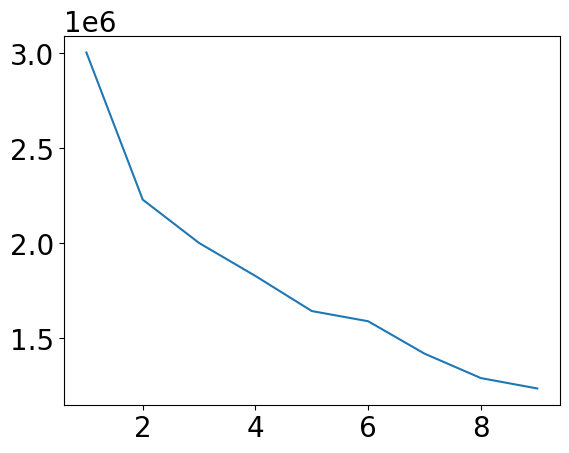

In [512]:
# let's make the elbow graph from the code above, using the 'scoresKM1' table
sns.lineplot(x=scoresKM1.keys(), y=scoresKM1.values())
plt.show()

Okay, the score is not awesome, but it looks like we can cut the clusters down to 3.

In [513]:
# second try, using 3 clusters
kmeans_modelKM2 = KMeans(n_clusters=3,n_init=10)
kmeans_modelKM2.fit(DiffYearKM)
y_predKM2 = kmeans_modelKM2.predict(DiffYearKM)

In [514]:
y_predKM2 = kmeans_modelKM2.predict(DiffYearKM)
y_predKM2

array([0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

In [515]:
scoresKM2 = {}

for k in range(1, 10):
  kmeans_modelKM2 = KMeans(n_clusters=k, n_init=10)
  kmeans_modelKM2.fit(DiffYearKM)
# The lowest SSE values of all the different initiations
  scoresKM2[k] = kmeans_modelKM2.inertia_

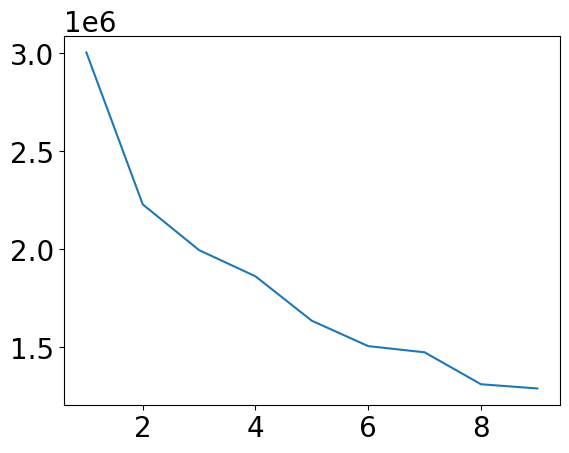

In [516]:
# let's make the elbow graph from the code above, using the 'scoresKM2' table
sns.lineplot(x=scoresKM2.keys(), y=scoresKM2.values())
plt.show()

In [517]:
silhouette_score(DiffYearKM, y_predKM2)

0.2535799877338409

Well, this model performed a little better. But still unsatisfying. Let's get some assistance on how many clusters to ask for. We're going to use a dendrogram.

In [518]:
from sklearn.cluster import AgglomerativeClustering

hierarchy_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_predAC2 = hierarchy_model.fit_predict(DiffYearKM)

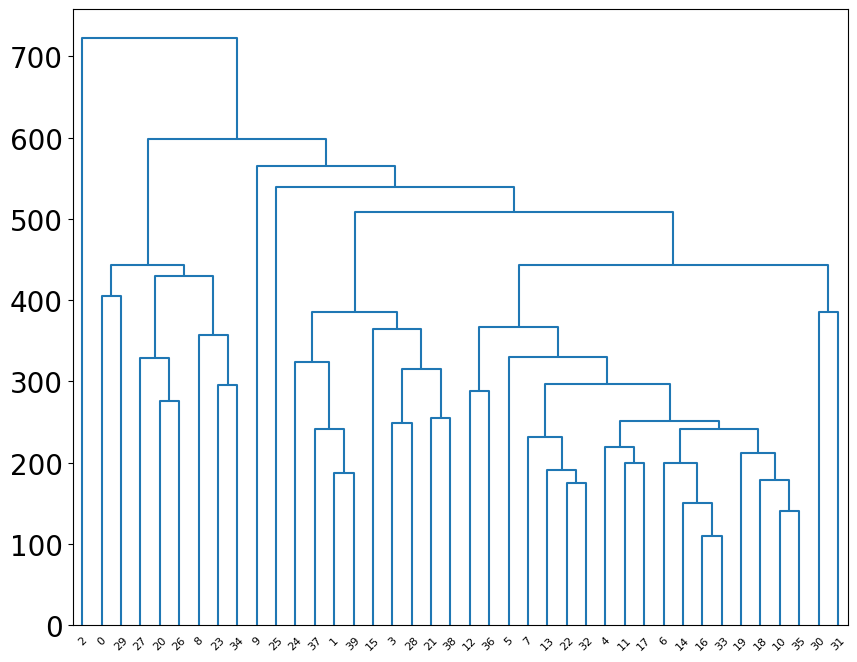

In [519]:
# Import scipy's linkage function to conduct the clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

linkage_matrix = linkage(DiffYearKM, method='complete')

plt.figure(figsize=(10,8))
dendrogram(linkage_matrix, color_threshold=6)
plt.show()

This is a bit of a mess, but I see 7 clusters in there, or rather 3 true groups, 1 group of 2, and 3 weirdos who don't fit in anywhere else. So, let's try 7 groups and see if we get a better fit. I will keep in mind that this may defy interpretability later, but... we'll come to that when we come to it. Let's also try a different linkage. 

In [550]:
# let's try a 'ward' linkage
from sklearn.cluster import AgglomerativeClustering

hierarchy_model = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_predAC3 = hierarchy_model.fit_predict(DiffYearKM)
y_predAC3

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1], dtype=int64)

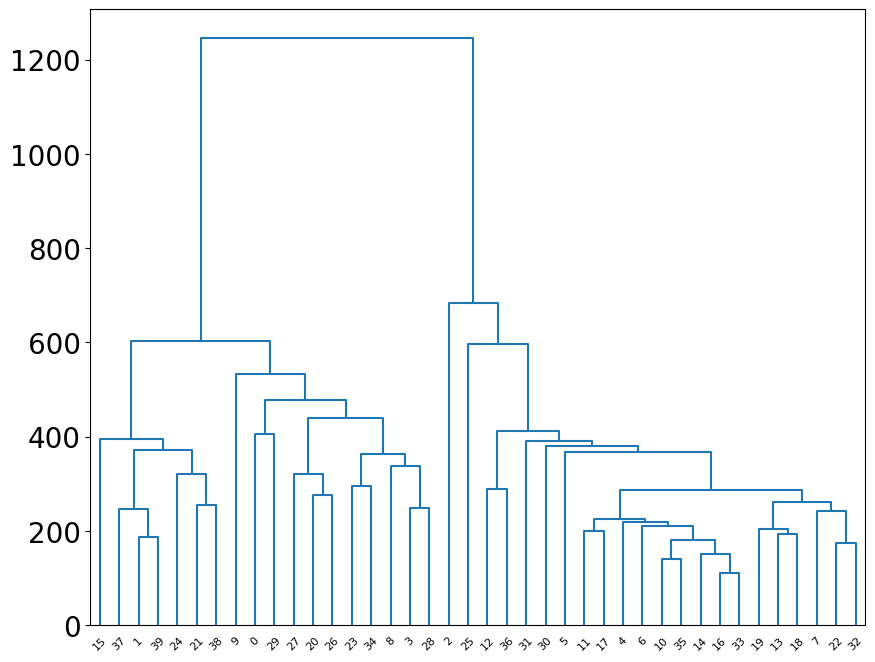

In [551]:
linkage_matrix = linkage(DiffYearKM, method='ward')

plt.figure(figsize=(10,8))
dendrogram(linkage_matrix, color_threshold=6)
plt.show()

Wow, that looks a LOT better! Let's try a little bit of each. Since I can still see 7 groups of data in both diagrams, let's first try 7 clusters.

In [520]:
# third try, using 7 clusters
kmeans_modelKM3 = KMeans(n_clusters=7,n_init=20)
kmeans_modelKM3.fit(DiffYearKM)
y_predKM3 = kmeans_modelKM3.predict(DiffYearKM)

In [521]:
y_predKM3 = kmeans_modelKM3.predict(DiffYearKM)
y_predKM3

array([0, 2, 4, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 2,
       1, 0, 2, 5, 3, 3, 3, 6, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2])

In [527]:
scoresKM3 = {}

for k in range(1, 10):
  kmeans_modelKM3 = KMeans(n_clusters=k, n_init=10)
  kmeans_modelKM3.fit(DiffYearKM)
# The lowest SSE values of all the different initiations
  scoresKM3[k] = kmeans_modelKM3.inertia_

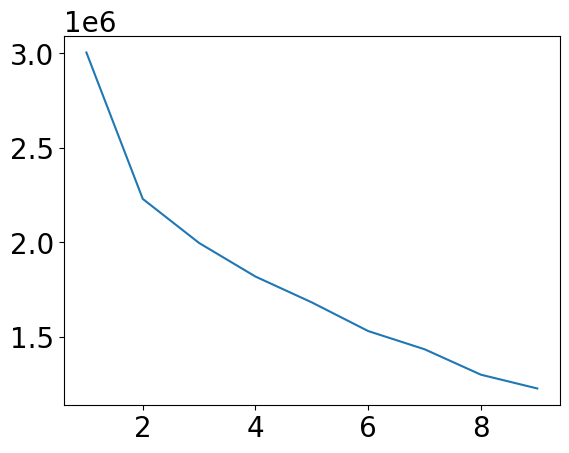

In [523]:
# let's make the elbow graph from the code above, using the 'scoresKM3' table
sns.lineplot(x=scoresKM3.keys(), y=scoresKM3.values())
plt.show()

In [524]:
silhouette_score(DiffYearKM, y_predKM3)

0.2233165748677018

Okay, well I can stop here on this one. This score is actually worse than the model using 3 clusters. Let's do one final attempt with 2 clusters, as that one is the most supported in the second dendrogram.

In [525]:
# third try, using 2 clusters
kmeans_modelKM4 = KMeans(n_clusters=2,n_init=10)
kmeans_modelKM4.fit(DiffYearKM)
y_predKM4 = kmeans_modelKM4.predict(DiffYearKM)

In [526]:
y_predKM4 = kmeans_modelKM4.predict(DiffYearKM)
y_predKM4

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0])

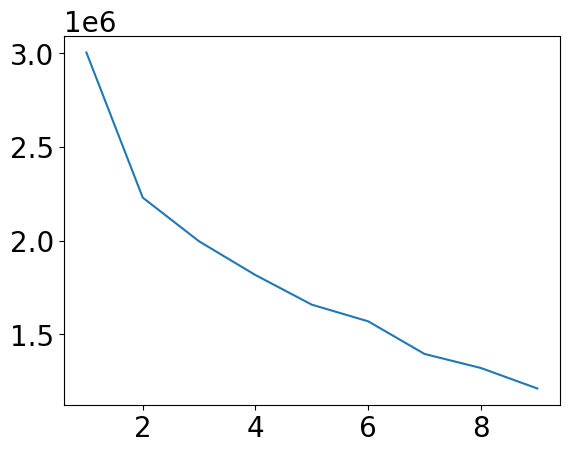

In [528]:
# let's make the elbow graph from the code above, using the 'scoresKM3' table
sns.lineplot(x=scoresKM4.keys(), y=scoresKM4.values())
plt.show()

In [529]:
silhouette_score(DiffYearKM, y_predKM4)

0.2474163954630945

The cluster analysis with 3 groupings was still slightly better! Let's interpret this keeping in view biological significance and using visualizations to reinforce this.

In [408]:
# include the 'group' variable into the table, so that we can separate the species graphically
AreaYeardf['group'] = y_pred3.tolist()

In [410]:
AreaYeardf.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\AreaYeardf_wgroup.csv", index=True)

In [409]:
AreaYeardf.head()

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,group
common_name,,,,,,,,,,,,,,,,,,,,,
American Redstart,129.886093,302.289206,126.289002,216.786103,115.117135,205.398519,234.253657,231.216553,245.408476,182.469615,...,337.759105,338.110870,348.075453,368.131195,395.653071,352.466573,336.882674,367.310131,357.307791,0
American Robin,235.026508,332.332345,297.769576,363.537287,222.551629,262.110009,351.244603,364.920917,260.570468,254.788562,...,395.096552,403.569028,400.372374,404.092450,400.797451,397.531003,397.418039,395.081481,402.031550,0
American Tree Sparrow,158.408117,179.336399,319.071161,164.496778,153.082547,149.191688,242.234756,199.762190,56.895871,105.399831,...,333.085211,340.259821,336.645467,350.866763,346.881802,355.874573,351.634079,350.822670,322.153934,0
Barn Swallow,221.589235,264.508121,221.118548,318.225467,224.956113,229.605150,312.558099,340.331330,268.308691,234.541690,...,396.096570,393.653892,401.537206,401.494006,408.759980,397.003004,399.205301,393.399716,399.703728,0
Black-chinned Hummingbird,116.268879,78.902839,123.249152,136.641634,133.581550,133.566039,159.477559,163.413584,162.168597,83.421753,...,224.571595,210.491259,220.521501,220.223727,221.383856,218.133286,223.338213,222.541032,221.253910,1


I'm going to export this data and work with it in Tableau to see if I can tease out the ways in which this model has separated the data!

In [437]:
# AreaYeardf.reset_index(inplace=True)

In [450]:
# polygoncluster = AreaYeardf.drop(columns=['level_0', 'index'])

In [448]:
# I need to lengthen it - it was in wide format for the analysis.
value_vars = [1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

PDdf = polygoncluster.melt(id_vars=['common_name', 'group'], value_vars=value_vars)

In [449]:
PDdf.head()

,common_name,group,year,value
0,American Redstart,0,1973,129.886093
1,American Robin,0,1973,235.026508
2,American Tree Sparrow,0,1973,158.408117
3,Barn Swallow,0,1973,221.589235
4,Black-chinned Hummingbird,1,1973,116.268879


In [451]:
PDdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   common_name  2040 non-null   object 
 1   group        2040 non-null   int64  
 2   year         2040 non-null   object 
 3   value        2040 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 63.9+ KB


In [452]:
PDdf.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\PDdf.csv", index=True)

Looking at the data in tableau, the k-means analysis clustered the groups based on the amount of variation in the birds' ranges. Most of the birds in group '0' are long-distance migrants, or birds who have highly variable ranges. Most of the birds in group '1' are birds that have a limited range, or birds whose migration distance is relatively short. This clustering analysis will be quite useful if I'm able to find the time to look at the range expansion, as I'm more likely to find significant differences by looking at groups with high variation separately from those with low variation. Success!

In [535]:
# I want to visualize the polygons in tableau, which means I need to export the polygons, not the areas, file as a shape file. I'll save as .csv first as my working copy.
convex_hull_areas.head()

,common_name,year,area,convex_hull_year
0,American Redstart,1973,129.886093,"POLYGON ((-117.24220305 32.67595415, -119.5107..."
1,American Redstart,1974,302.289206,"POLYGON ((-114.4665626 32.8819198, -118.520604..."
2,American Redstart,1975,126.289002,"POLYGON ((-115.0350952 32.7156663, -118.486568..."
3,American Redstart,1976,216.786103,"POLYGON ((-110.8110955 31.4991144, -117.100374..."
4,American Redstart,1977,115.117135,"POLYGON ((-117.2449932 32.68582, -119.4878153 ..."


In [536]:
convex_hull_areas.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\convex_hull_areas.csv", index=True)

In [537]:
# okay, now let's see what geometric drivers I can use on this platform...
import fiona
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [ ]:
# I need to specify that the polygons are shapes and set them as the 'geometry' for the file before I can convert it to a shape file.
polygons = geopandas.GeoDataFrame(convex_hull_areas, geometry = convex_hull_year, crs='EPSG:4326')

In [542]:
polygons = gpd.GeoDataFrame(convex_hull_areas, geometry='convex_hull_year', crs='EPSG:4326')

In [545]:
polygons.head()

,common_name,year,area,convex_hull_year
0,American Redstart,1973,129.886093,"POLYGON ((-117.24220 32.67595, -119.51071 33.2..."
1,American Redstart,1974,302.289206,"POLYGON ((-114.46656 32.88192, -118.52060 32.9..."
2,American Redstart,1975,126.289002,"POLYGON ((-115.03510 32.71567, -118.48657 32.8..."
3,American Redstart,1976,216.786103,"POLYGON ((-110.81110 31.49911, -117.10037 32.5..."
4,American Redstart,1977,115.117135,"POLYGON ((-117.24499 32.68582, -119.48782 33.2..."


In [546]:
print(polygons.geometry.type)

0       Polygon
1       Polygon
2       Polygon
3       Polygon
4       Polygon
         ...   
2026    Polygon
2027    Polygon
2028    Polygon
2029    Polygon
2030    Polygon
Length: 2031, dtype: object


In [547]:
# Filter out points, keeping only polygon geometries
polygons = polygons[polygons.geometry.type == 'Polygon']

In [543]:
# import geopandas as gpd
# from shapely import wkt

# # Convert 'convex_hull_year' column from WKT to shapely objects
# convex_hull_areas['geometry'] = convex_hull_areas['convex_hull_year'].apply(wkt.loads)

# # Now create a GeoDataFrame with the correct geometry
# polygons = gpd.GeoDataFrame(convex_hull_areas, geometry='geometry', crs='EPSG:4326')

# # After defining the geometry, you can export to a shapefile
# polygons.to_file(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\convex_hull_areas.shp")

In [548]:
polygons.to_file(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\convex_hull_areas.shp", index=True)

C:\Users\ca0pa\AppData\Local\Temp\ipykernel_22304\3591675666.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons.to_file(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\convex_hull_areas.shp", index=True)


I've finished ploting those polygons in Tableau, and they're ready for the presentation! I will save them on Tableau public and provide a link in the readme file.

Now, since I have a bit of time, I'd like to see if I can tease the dates of the northernmost latitudes of each species on every day in April, then compare those with another time series!
Let's start with that geobird data I started with last time.

In [594]:
import pandas as pd
geobird = pd.read_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\birdsgeo.csv")

In [601]:
geobird.head()

,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,year,month,julian,dayofyear
0,2033,Eurasian Collared-Dove,4,US,California,US-CA,Alameda,US-CA-001,37.862962,-122.314739,1983-07-04,POINT (-122.3147392 37.8629622),1983,7,2445519.5,185
1,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.585126,-121.698818,2000-08-04,POINT (-121.6988182 37.5851261),2000,8,2451760.5,217
2,2033,Eurasian Collared-Dove,5,US,California,US-CA,Alameda,US-CA-001,37.660119,-121.732807,2004-05-22,POINT (-121.7328072 37.6601188),2004,5,2453147.5,143
3,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.763607,-122.258200,2005-07-15,POINT (-122.2582 37.763607),2005,7,2453566.5,196
4,2033,Eurasian Collared-Dove,12,US,California,US-CA,Alameda,US-CA-001,37.616214,-121.694949,2005-09-10,POINT (-121.6949491 37.6162145),2005,9,2453623.5,253


In [598]:
geobird = geobird.drop(columns='Unnamed: 0')

In [600]:
# I had to delete a couple of relic columns, so let's save this again as a true working copy
geobird.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\geobird.csv", index=True)

In [602]:
# This is roundabout, but I would like to just look at april, throughout the years for these species.
aprilgeobird = geobird[geobird.month > 3]

In [604]:
aprilgeobird.head()

,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,year,month,julian,dayofyear
0,2033,Eurasian Collared-Dove,4,US,California,US-CA,Alameda,US-CA-001,37.862962,-122.314739,1983-07-04,POINT (-122.3147392 37.8629622),1983,7,2445519.5,185
1,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.585126,-121.698818,2000-08-04,POINT (-121.6988182 37.5851261),2000,8,2451760.5,217
2,2033,Eurasian Collared-Dove,5,US,California,US-CA,Alameda,US-CA-001,37.660119,-121.732807,2004-05-22,POINT (-121.7328072 37.6601188),2004,5,2453147.5,143
3,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.763607,-122.258200,2005-07-15,POINT (-122.2582 37.763607),2005,7,2453566.5,196
4,2033,Eurasian Collared-Dove,12,US,California,US-CA,Alameda,US-CA-001,37.616214,-121.694949,2005-09-10,POINT (-121.6949491 37.6162145),2005,9,2453623.5,253


In [605]:
aprilgeobird = aprilgeobird[aprilgeobird.month < 5]

In [606]:
aprilgeobird.head()

,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,year,month,julian,dayofyear
5,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.587895,-121.607407,2007-04-28,POINT (-121.6074071 37.587895),2007,4,2454218.5,118
6,2033,Eurasian Collared-Dove,2,US,California,US-CA,Alameda,US-CA-001,37.660119,-121.732807,2007-04-29,POINT (-121.7328072 37.6601188),2007,4,2454219.5,119
20,2033,Eurasian Collared-Dove,2,US,California,US-CA,Alameda,US-CA-001,37.681831,-121.768059,2008-04-09,POINT (-121.7680588 37.6818314),2008,4,2454565.5,100
21,2033,Eurasian Collared-Dove,1,US,California,US-CA,Alameda,US-CA-001,37.641932,-122.151701,2008-04-13,POINT (-122.1517012 37.6419316),2008,4,2454569.5,104
22,2033,Eurasian Collared-Dove,4,US,California,US-CA,Alameda,US-CA-001,37.660119,-121.732807,2008-04-27,POINT (-121.7328072 37.6601188),2008,4,2454583.5,118


In [607]:
aprilgeobird.shape

(822883, 16)

In [608]:
# Okay, for this last analysis, this is going to be my working file.
aprilgeobird.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\aprilgeobird.csv", index=True)

Now, I want to make another dataset with only the maximum latitude values per day per year for each species. Ideally, this will result in something I can use to see if birds are migrating earlier in the year as time goes by, as well as potentially expanding their ranges northward. Let's start by limiting these observations to only their most northern. HOWEVER, I want to eliminate oddballs that show up really far north, as I don't care about those. So, I'll take the top ten most northern points, and look at those AS WELL as drop the value with the highest latitude if the count number is only 1.

In [614]:
def calculate_maxlat_perday(df):
    # Group by 'common_name' and 'julian'
    grouped = aprilgeobird.groupby(['common_name', 'julian'])
    
    # List to store the output data
    maxlat_data = []
    
    # Iterate over each group
    for (common_name, julian), group in grouped:
        # sort the data by latitude, descending
        sorted_group = group.sort_values('mean_latitude', ascending=False)
        # ignore/temporarlly drop the observation with the highest latitude if total_count < 2
        if sorted_group.iloc[0]['total_count'] < 2:
            sorted_group = sorted_group.iloc[1:]
        # Make a list of the 10 largest values of latitude
        top_lat_group = sorted_group.head(10)
            
        # Append the data from 'top_lat_group' to 'maxlat_data'
        for index, row in top_lat_group.iterrows():
            maxlat_data.append(row)

    # Convert to geodatabase, and make sure the column names in the original dataframe are used
    maxlat_gdf = gpd.GeoDataFrame(maxlat_data, columns=df.columns)
    
    # Return the GeoDataFrame
    return maxlat_gdf

# Apply the function to the dataset
maxlat = calculate_maxlat_perday(aprilgeobird)

In [615]:
# The working dataset
maxlat.head()

,taxonomic_order,common_name,total_count,country_code,state,state_code,county,county_code,mean_latitude,mean_longitude,observed_date,geometry,year,month,julian,dayofyear
2250595,33378,American Redstart,2,US,California,US-CA,Orange,US-CA-059,33.701064,-118.006382,1986-04-12,POINT (-118.006382 33.7010644),1986,4,2446532.5,102
2248499,33378,American Redstart,2,US,California,US-CA,Imperial,US-CA-025,33.280674,-115.579691,2002-04-20,POINT (-115.5796909 33.2806736),2002,4,2452384.5,110
2248527,33378,American Redstart,6,US,California,US-CA,Imperial,US-CA-025,33.192357,-115.604153,2004-04-03,POINT (-115.6041527 33.1923574),2004,4,2453098.5,94
2250676,33378,American Redstart,2,US,California,US-CA,Orange,US-CA-059,33.549407,-117.709837,2004-04-11,POINT (-117.709837 33.5494066),2004,4,2453106.5,102
2250678,33378,American Redstart,2,US,California,US-CA,Orange,US-CA-059,33.549407,-117.709837,2004-04-29,POINT (-117.709837 33.5494066),2004,4,2453124.5,120


In [616]:
maxlat.shape

(207945, 16)

In [617]:
maxlat['common_name'].value_counts()

common_name
Yellow-rumped Warbler        11060
American Robin               10694
Song Sparrow                 10420
Orange-crowned Warbler        9633
Mourning Dove                 9565
Tree Swallow                  8960
Barn Swallow                  8585
Savannah Sparrow              8198
Rufous Hummingbird            8152
Wilson's Warbler              7733
Western Bluebird              6817
Say's Phoebe                  6265
Chipping Sparrow              6251
Black-chinned Hummingbird     6205
Varied Thrush                 6192
White-throated Swift          6066
Yellow Warbler                5938
Lark Sparrow                  5685
Horned Lark                   5544
Costa's Hummingbird           5172
Eurasian Collared-Dove        5099
White-winged Dove             5092
Black-throated Sparrow        5002
Lucy's Warbler                4984
Vaux's Swift                  4404
Gray Flycatcher               3821
Calliope Hummingbird          3750
Hermit Warbler                3176
Common P

Yikes. Only 80 lines for Redstarts? That is weird. I bet there's something interesting there. Maybe they just migrate north on the other side of the continental divide and south on the west side I know that happens with some eastern species, and Redstart fits that pattern. 

In [620]:
import numpy as np
maxlat.describe(exclude=np.number)

,common_name,country_code,state,state_code,county,county_code,observed_date,geometry
count,207945,207945,207945,207945,207945,207945,207945,207945
unique,38,2,8,8,242,265,1529,94054
top,Yellow-rumped Warbler,US,California,US-CA,Metro Vancouver,CA-BC-GV,2023-04-29,POINT (-123.0847102 39.0020417)
freq,11060,150673,60001,60001,7010,7010,352,1169


In [621]:
maxlat.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 207945 entries, 2250595 to 6482026
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   taxonomic_order  207945 non-null  int64  
 1   common_name      207945 non-null  object 
 2   total_count      207945 non-null  int64  
 3   country_code     207945 non-null  object 
 4   state            207945 non-null  object 
 5   state_code       207945 non-null  object 
 6   county           207945 non-null  object 
 7   county_code      207945 non-null  object 
 8   mean_latitude    207945 non-null  float64
 9   mean_longitude   207945 non-null  float64
 10  observed_date    207945 non-null  object 
 11  geometry         207945 non-null  object 
 12  year             207945 non-null  int64  
 13  month            207945 non-null  int64  
 14  julian           207945 non-null  float64
 15  dayofyear        207945 non-null  int64  
dtypes: float64(3), int64(5), obj

This is fine. I'm not going to use observed_date.

In [622]:
maxlat.to_csv(r"C:\Users\ca0pa\Desktop\Final project\Data ebird\WorkingData\maxlat.csv", index=True)

I love where this is going, but I am running out of time to add further analyses into the mix. I'm going to stop here while I complete my presentation and get everything organized in git. Maybe I'll have another opportunity to circle back to this and knock out one more analysis.